## Spectral Clustering and Semi-Supervised Learning

#### This notebook contains different values and imports that can be used in this practical session.
#### Please keep the same variable names when provided in your report to make the work of teaching assistants easier. 
#### You can still change the values given or the sizes of the datasets treated if you believe it is usefull to illustrate your point.

#### You can directly edit the markdown boxes to add your comments and answers to the questions

In [1]:
# Question 1 (imports and advised values):
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

n_samples = 200 # You can change these values
noise_level_list = [.05, .1, .2] # You can change these values

### Question 1 : Complete the code in the box below

In [2]:
noisy_moons = make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons

In [3]:
def plot_dataset(X, y, noise):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_facecolor('white')
    
    ax.scatter(X[y == 1][:,0], X[y == 1][:,1], alpha=0.8, label="y = 1")
    ax.scatter(X[y == 0][:,0], X[y == 0][:,1], alpha=0.8, label="y = 0")

    ax.set_xlabel("X1", fontsize=15)
    ax.set_ylabel("X2", fontsize=15)
    ax.set_title("Toy dataset (noise=%.02f)" % noise, fontsize=15)
    plt.legend()
    
    plt.tight_layout()
    return

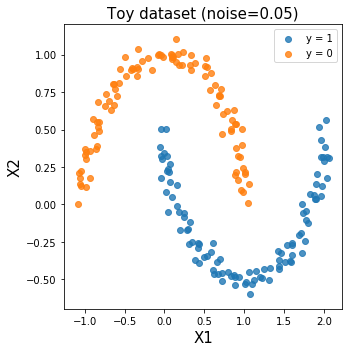

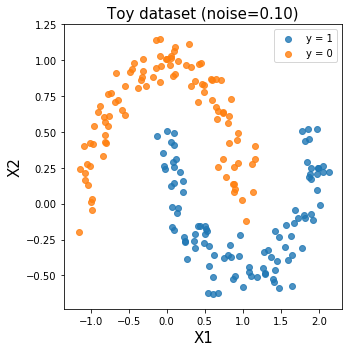

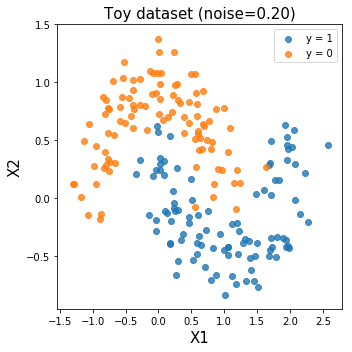

In [4]:
for noise in noise_level_list:
    noisy_moons = make_moons(n_samples=n_samples, noise=noise)
    X, y = noisy_moons
    plot_dataset(X, y, noise)

#### Comment: 

We observe that as the noise level increases, the points are more spread.

### Question 2 : Complete the code in the box below

In [5]:
from sklearn.neighbors import kneighbors_graph
import networkx as nx
from scipy.sparse import find
n_neighbors_list = [1, 5, 10] # You can change these values

In [6]:
def plot_dataset_graph(n_samples, l_noise, l_k):
    
    # data
    datasets_X = []
    datasets_y = []
    for noise in l_noise:
        noisy_moons = make_moons(n_samples=n_samples, noise=noise)
        X, y = noisy_moons
        datasets_X.append(X)
        datasets_y.append(y)
    
    # plot
    for k in l_k:
        fig = plt.figure(figsize=(15, 5))
        axes = []
        for i, noise in enumerate(l_noise):
            X, y = datasets_X[i], datasets_y[i]

            ax = plt.subplot2grid((1, len(l_noise)), (0, i))
            ax.set_facecolor('white')
            axes.append(ax)

            ax.scatter(X[y == 1][:,0], X[y == 1][:,1], color="steelblue", alpha=0.8, label="y = 1")
            ax.scatter(X[y == 0][:,0], X[y == 0][:,1], color="forestgreen", alpha=0.8, label="y = 0")

            kn = kneighbors_graph(X, n_neighbors=k)
            for i in range(n_samples):
                x1i, x2i = X[i, 0], X[i, 1] 
                neighbors_i = find(kn[i])[1]
                x1_neighbors, x2_neighbors = X[neighbors_i][:, 0], X[neighbors_i][:, 1]
                for j in range(len(x1_neighbors)):
                    ax.plot((x1i, x1_neighbors[j]), (x2i, x2_neighbors[j]), color="firebrick", alpha=0.5)
    
            ax.set_xlabel("X1", fontsize=15)
            ax.set_ylabel("X2", fontsize=15)
            ax.set_title("Toy dataset (noise=%.02f, k=%i)" % (noise, k), fontsize=15)

        plt.legend()
        plt.tight_layout()
    
    return

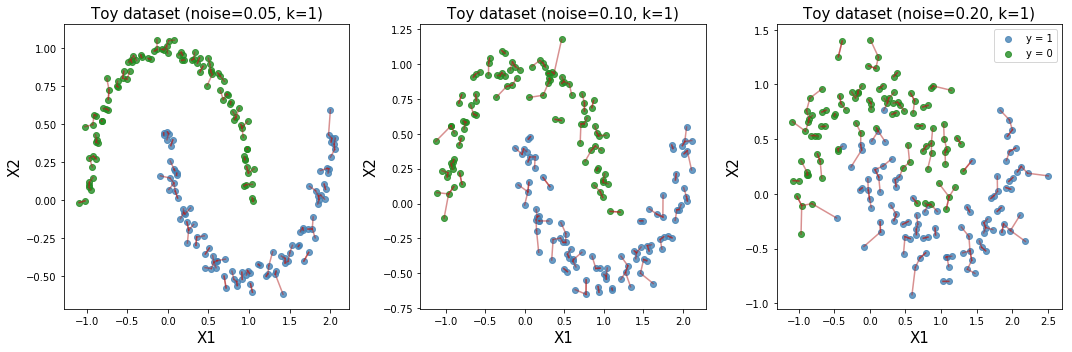

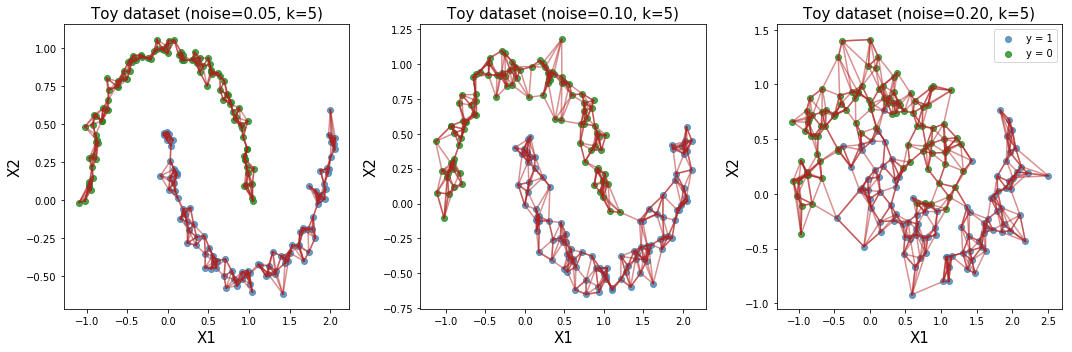

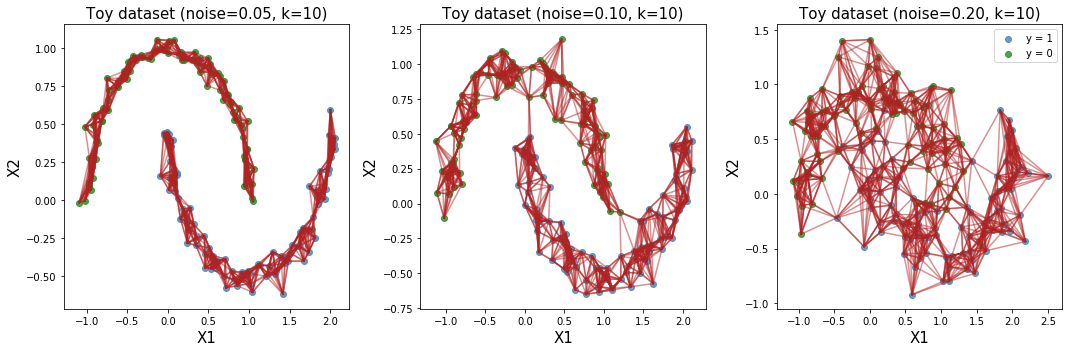

In [7]:
plot_dataset_graph(n_samples=200, l_noise=noise_level_list, l_k=n_neighbors_list)

### Question 3 : Optimization problem 


The optimization problem leading to the Normalized-cut Spectral Clustering is: 

$$
\underset{f \in R^n}{min} \frac{f^T Lf}{f^T Df}  \text{ subject to } f^T D 1_n = 0
$$

- with $f_i$ the cluster indicator, i.e. $f_i = \sqrt{ \frac{vol(\bar{A})}{vol(A)}}$ if vertex $v_i \in A$,  $f_i = \sqrt{ \frac{vol(A)}{vol(\bar{A})}}$ if $v_i \in \bar{A}$, 

- with $L$ the Laplacian of the graph, i.e. $L = D - W$, where  W is the adjacency matrix and D is the degree matrix ($d_{ii} = \sum_j w_{ij}$ if $i= j$ and $d_{ij} = 0$ if $i\neq j $). 


This problem boils down to solve the generalized eigenvalue problem : 
$ (D-W)f = \lambda Df $.



Note that this optimization problem is equivalent to find minimized $\text{Ncut} = \frac{cut(A,\bar{A})}{vol(A)} + \frac{cut(\bar{A},A)}{vol(\bar{A})}$

- with $cut(A,\bar{A}) = \sum_{t \in A, u \in \bar{A}}w_{t,u}$,
- with $vol(A) = \sum_{t \in A, u \in V}w_{t,u}$ ($V$ is the set of vertices).

Indeed, we have $vol(V) = f^TDf$, $f^TLf = vol(V) \times Ncut(A,\bar{A})$ and $(Df)^T\mathbb{1}_{n} = 0$.

### Question 4 : Complete the code in the box below

In [8]:
n_neighbors_list = [1, 5, 10, 15, 20] # You can change these values

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.cluster import SpectralClustering
from itertools import product

In [10]:
def plot_sp_clustering(n_samples, l_noise, l_k):
  
    for i, (k, noise) in enumerate(product(n_neighbors_list, noise_level_list)):

        # data
        X, y = make_moons(n_samples=n_samples, noise=noise)
        kn = kneighbors_graph(X, n_neighbors=k)
        
        # we make the adjency matrix symetric
        sim_kn = (kn + kn.T) / 2
        
        # we fit the spectral clustering and predict y
        sc = SpectralClustering(n_clusters=2, 
                                random_state=13, 
                                affinity="precomputed", 
                                n_neighbors=k, 
                                eigen_solver="arpack")
        sc.fit(sim_kn)
        y_predict = sc.labels_

        # accuracy
        score = accuracy_score(y, y_predict)

        # plot
        plt.rc('figure', figsize=(15, 20))
        plt.subplot(len(n_neighbors_list), len(noise_level_list), i + 1)
        plt.scatter(X[y_predict == 1][:,0], X[y_predict == 1][:,1], alpha=0.8, label="y_predict = 1")
        plt.scatter(X[y_predict == 0][:,0], X[y_predict == 0][:,1], alpha=0.8, label="y_predict = 0")
        plt.xlabel("X1", fontsize=15)
        plt.ylabel("X2", fontsize=15)
        plt.title("(k=%i, noise=%.02f, accuracy=%.02f)" % (k, noise, score), fontsize=15)
        plt.legend()
        plt.tight_layout()
        
    return

/home/arthur/miniconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


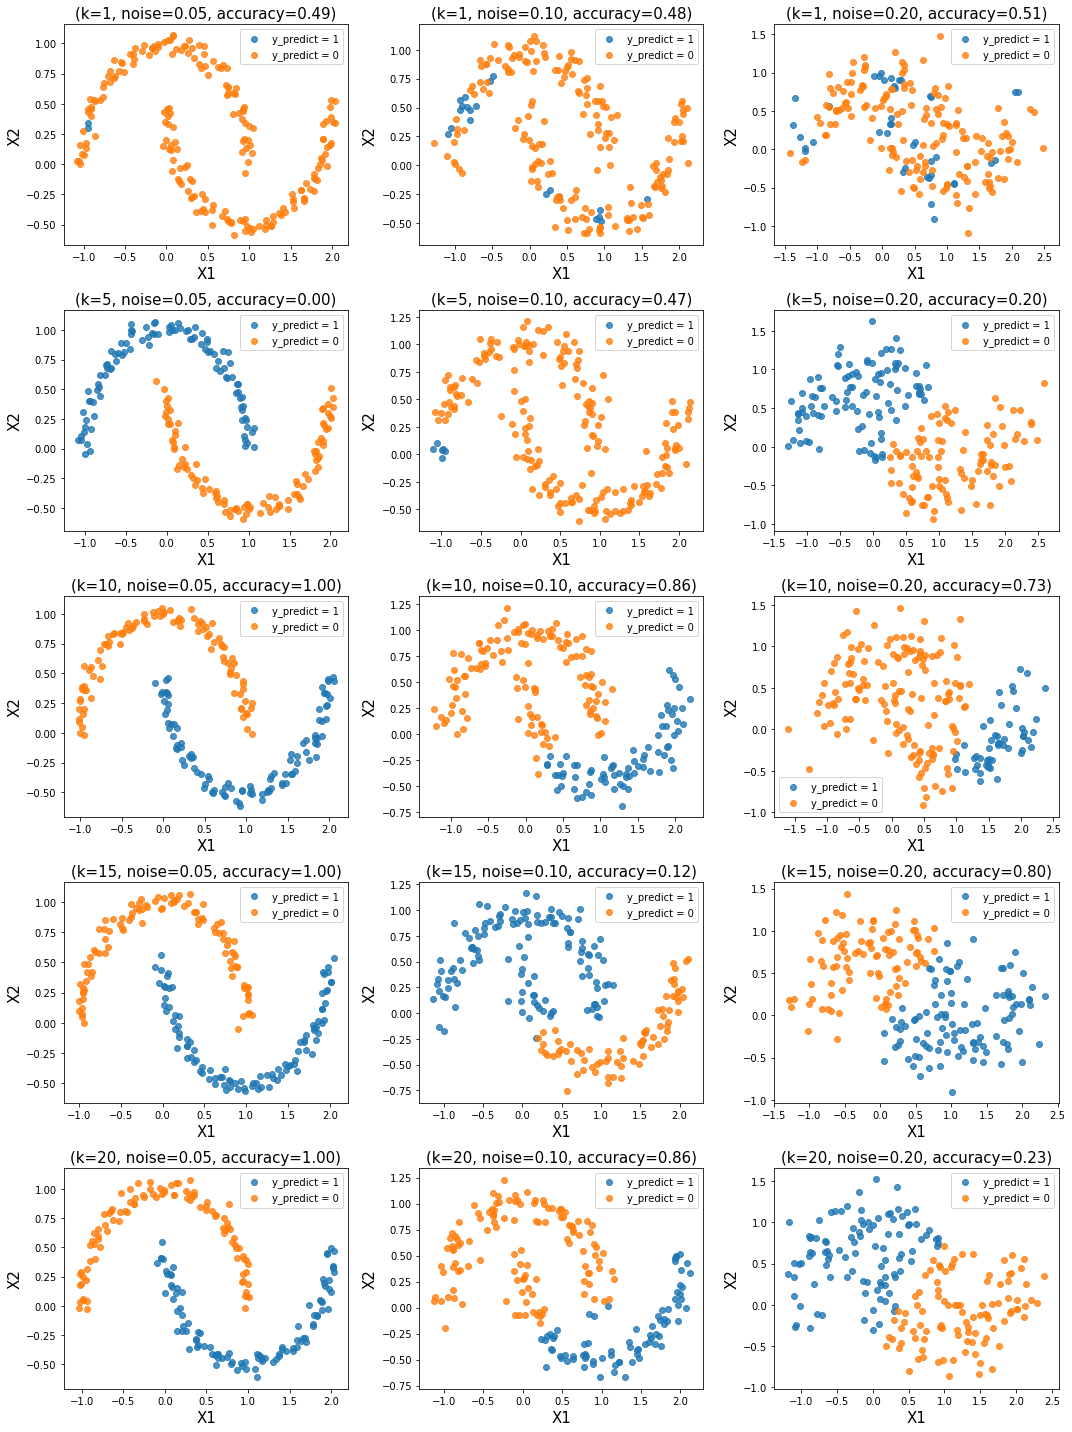

In [11]:
plot_sp_clustering(n_samples=200, l_noise=noise_level_list, l_k=n_neighbors_list)

#### Comments:



A large value of $k$ seems to make the cluster robust and gives better results (i.e. larger accuracy) whatever the noise level is. However, a too large level of $k$ could lead to underfitting. On the contrary, when $k$ is too small, we observe a situation of overfitting: the points are scattered.

The optimal value of $k$ (trade-off between bias and variance) depends on the level of noise. For a low level of noise (for example 0.05), a value of $k$ between 10 and 20 allows a quasi perfect prediction. When the level of noise is too large, the model is less likely to generalize to unseen data, no matter the level of $k$: the clustering is bad.



### Question 5 : Complete the code in the box below

In [12]:
def cosine_similarity(A, B):
    return A.dot(B).sum() / np.sqrt(A.dot(A).sum() * B.dot(B).sum())


def matrix_representation(y_pred):
    n = y_pred.size
    M = np.zeros((n, n))
    for i in range(n):
        i_label = y_pred[i]
        for j in range(n):
            j_label = y_pred[j]
            if i_label == j_label and i != j:
                M[i, j] = 1
    return M


def stability(clustering_algo, dataset, B, C, precomputed=False, k=None): 
    """
    clustering_algo: algorithm to test
    dataset: data
    B: number of bootstrap
    C: number of clusters
    precomputed: boolean if the linkage is precomputed of not
    k: number of neighbors (in case the linkage is precomputed)
    """
    X, y = dataset
    n = X.shape[0]
    clustering_algo.n_clusters = C
    
    # we compute the cluster with the entire dataset
    if not precomputed:
        clustering_algo.fit(X)
    else:
        kn = kneighbors_graph(X, n_neighbors=k, include_self=False)
        sim_kn = (kn + kn.T) / 2
        if precomputed == "connectivity":
            clustering_algo.connectivity = sim_kn
            clustering_algo.fit(X)
        else:
            clustering_algo.fit(sim_kn)
    y_pred = clustering_algo.labels_
    
    # we build the matrix representation
    M = matrix_representation(y_pred)
    
    # bootstrap
    ix = [i for i in range(n)]
    size = int(0.8 * len(ix))
    l_similarity = []
    for b in range(B):
        
        # we extract a sample of the dataset
        ix_partition = np.random.choice(ix, size=size, replace=False)
        X_partition = X[ix_partition, :]
        
        # we compute the cluster with the partition
        if not precomputed:
            clustering_algo.fit(X_partition)
        else:
            kn = kneighbors_graph(X_partition, n_neighbors=k, include_self=False)
            sim_kn = (kn + kn.T) / 2
            if precomputed == "connectivity":
                clustering_algo.connectivity = sim_kn
                clustering_algo.fit(X_partition)
            else:
                clustering_algo.fit(sim_kn)
        y_pred = clustering_algo.labels_
        
        # we build the matrix representation
        M_partition = matrix_representation(y_pred)
        
        # we compute the similarity between matrix representations
        similarity = cosine_similarity(M[ix_partition[:, None], ix_partition], M_partition)
        l_similarity.append(similarity)
    
    return l_similarity

### Question 6 : Complete the code in the box below

*Measure the stability of spectral clustering on a non-noisy moon dataset and on a noisy moon dataset. Given C = 2, does the stability criterion help to choose k, the hyperparameter of the graph construction ?*

In [13]:
def stability_test(algorithm, B, C, n_samples, low_noise, high_noise, max_k, precomputed=False):
    
    # datasets
    dataset_nonoisy = make_moons(n_samples=n_samples, noise=low_noise)
    dataset_noisy = make_moons(n_samples=n_samples, noise=high_noise)

    d_noisy = {}
    d_non_noisy = {}
    for k in range(1, max_k + 1):
        # stability measures
        stability_non_noisy = stability(clustering_algo=algorithm, dataset=dataset_nonoisy, B=B, C=C, precomputed=precomputed, k=k)
        stability_noisy = stability(clustering_algo=algorithm, dataset=dataset_noisy, B=B, C=C, precomputed=precomputed, k=k)
        d_non_noisy[k] = stability_non_noisy
        d_noisy[k] = stability_noisy
    return d_non_noisy, d_noisy


def plot_stability(d_non_noisy, d_noisy, title):
    plt.figure(figsize=(20, 10))
    x = [k for k in range(1, max_k + 1)]
    y_noise = []
    y_noise_up = []
    y_noise_low = []
    y_no_noise = []
    y_no_noise_up = []
    y_no_noise_low = []
    for k in range(1, max_k + 1):
        # noisy case
        m = np.mean(d_noisy[k])
        sd = np.std(d_noisy[k])
        y_noise.append(m)
        y_noise_up.append(min(m + sd, 1))
        y_noise_low.append(m - sd)

        # non-noisy case
        m = np.mean(d_non_noisy[k])
        sd = np.std(d_non_noisy[k])
        y_no_noise.append(m)
        y_no_noise_up.append(min(m + sd, 1))
        y_no_noise_low.append(m - sd)

    # plot
    plt.fill_between(x, y_noise_low, y_noise_up, color="steelblue", alpha=0.3, label="noisy standard deviation")
    plt.fill_between(x, y_no_noise_low, y_no_noise_up, color="forestgreen", alpha=0.3, label="non-noisy standard deviation")
    plt.plot(x, y_noise, color="steelblue", label="noisy data", linewidth=5)
    plt.plot(x, y_no_noise, color="forestgreen", label="non-noisy data", linewidth=5)
    for k in range(0, max_k + 1, 5):
        plt.axvline(x=k, ymin=0, ymax=2, linewidth=1, color='gray', linestyle=":")
    plt.legend(loc="lower right", prop={'size': 15})
    plt.xlabel("Number of neighbors k", fontsize=15)
    plt.ylabel("Average statibility score", fontsize=15)
    plt.title(title, fontsize=20)
    plt.xticks(x, x)
    plt.show()
    
    return

/home/arthur/miniconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


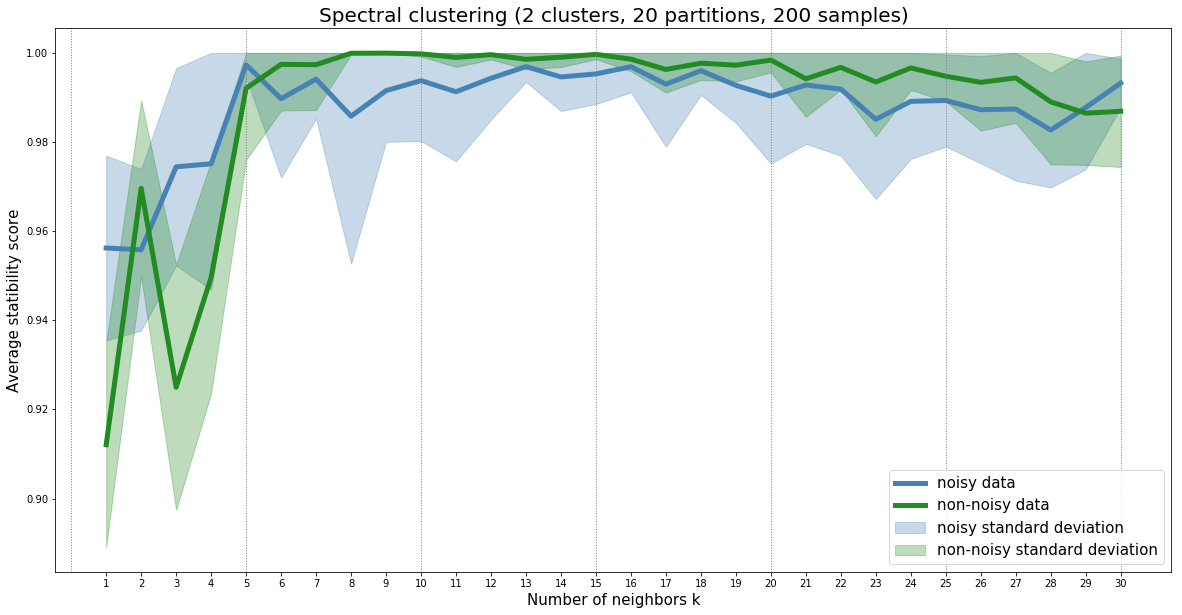

In [14]:
C = 2
B = 20
n_samples = 200
max_k = 30

# clustering algorithm
sc = SpectralClustering(random_state=13, 
                        affinity="precomputed", 
                        eigen_solver="arpack")
title = "Spectral clustering (%i clusters, %i partitions, %i samples)" % (C, B, n_samples)
    
d_non_noisy, d_noisy = stability_test(sc, B, C, n_samples, .05, .2, max_k, precomputed=True)
plot_stability(d_non_noisy, d_noisy, title)

#### Comment:

The data seems structured since there is no dramatic fall of stability between k=1 and k=2. For the non-noisy dataset, the higher level of stability, with a minimized variance, is reached approximatevelly for k taking values between 6 and 15. With a larger k, the variance raises again and the stability decreases. For the noisy dataset, the statibility seems to increase with k. For a large k (around 30), the noisy dataset seems more stable than the non-noisy one. Overall, the spectral clustering algorithm presents a great level of stability (the average cosine similarity between the entire dataset and its partitions stays over 0.9). Thus, the stability criterion could help to optimize k.

### Question 7 : Complete the code in the box below

In [15]:
# Now compute the stability of hierarchical clustering (you will choose the most appropriate distance
#between clusters) on the same datasets.
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import minkowski, cosine, euclidean, cityblock

In [16]:
# we first want to choose a metric which maximizes the distance between samples in different classes and 
# minimizes that within each class.

noise = .05
n_samples = 200

dist_l1 = []
dist_l2 = []
dist_euclidean = []
dist_cosine = []
dist_manhattan = []

X, y = make_moons(n_samples=n_samples, noise=noise)
for i in range(n_samples):
    u = X[i,:]
    y_i = y[i]
    l_j = np.random.choice([n for n in range(n_samples) if n != i], size=10)
    for j in l_j:
        v = X[j, :]
        y_j = y[j]    
        if y_i == y_j:
            dist_l1.append(minkowski(u, v, p=1))
            dist_l2.append(minkowski(u, v, p=2))
            dist_euclidean.append(euclidean(u, v))
            dist_cosine.append(cosine(u, v))
            dist_manhattan.append(cityblock(u, v))

mean_distance_l1 = round(np.mean(dist_l1), 3)
mean_distance_l2 = round(np.mean(dist_l2), 3)
mean_distance_euclidean = round(np.mean(dist_euclidean), 3)
mean_distance_cosine = round(np.mean(dist_cosine), 3)
mean_distance_manhattan = round(np.mean(dist_manhattan), 3)

dist_l1 = []
dist_l2 = []
dist_euclidean = []
dist_cosine = []
dist_manhattan = []

for i in range(n_samples):
    u = X[i,:]
    y_i = y[i]
    l_j = np.random.choice([n for n in range(n_samples) if n != i], size=10)
    for j in l_j:
        v = X[j, :]
        y_j = y[j]    
        if y_i != y_j:
            dist_l1.append(minkowski(u, v, p=1))
            dist_l2.append(minkowski(u, v, p=2))
            dist_euclidean.append(euclidean(u, v))
            dist_cosine.append(cosine(u, v))
            dist_manhattan.append(cityblock(u, v))

mean_distance_l1_diff = round(np.mean(dist_l1), 3)
mean_distance_l2_diff = round(np.mean(dist_l2), 3)
mean_distance_euclidean_diff = round(np.mean(dist_euclidean), 3)
mean_distance_cosine_diff = round(np.mean(dist_cosine), 3)
mean_distance_manhattan_diff = round(np.mean(dist_manhattan), 3)

ratio_l1 = round(mean_distance_l1 / mean_distance_l1_diff, 3)
ratio_l2 = round(mean_distance_l2 / mean_distance_l2_diff, 3)
ratio_euclidean = round(mean_distance_euclidean / mean_distance_euclidean_diff, 3)
ratio_cosine = round(mean_distance_cosine / mean_distance_cosine_diff, 3)
ratio_manhattan = round(mean_distance_manhattan / mean_distance_manhattan_diff, 3)

print("ratio = mean_distances_same_cluster / mean_distances_different_cluster")
print("------------------------------------------------------------------------", "\n")
print("l1 \t  | ratio:", ratio_l1, "\t | same cluster average:", mean_distance_l1, "\t | different cluster average:", mean_distance_l1_diff)
print("l2 \t  | ratio:", ratio_l2, "\t | same cluster average:", mean_distance_l2, "\t | different cluster average:", mean_distance_l2_diff)
print("euclidean | ratio:", ratio_euclidean, "\t | same cluster average:", mean_distance_euclidean, "\t | different cluster average:", mean_distance_euclidean_diff)
print("cosine \t  | ratio:", ratio_cosine, "\t | same cluster average:", mean_distance_cosine, "\t | different cluster average:", mean_distance_cosine_diff)
print("manhattan | ratio:", ratio_manhattan, "\t | same cluster average:", mean_distance_manhattan, "\t | different cluster average:", mean_distance_manhattan_diff)

ratio = mean_distances_same_cluster / mean_distances_different_cluster
------------------------------------------------------------------------ 

l1 	  | ratio: 0.6 	 | same cluster average: 1.16 	 | different cluster average: 1.932
l2 	  | ratio: 0.614 	 | same cluster average: 0.934 	 | different cluster average: 1.521
euclidean | ratio: 0.614 	 | same cluster average: 0.934 	 | different cluster average: 1.521
cosine 	  | ratio: 0.448 	 | same cluster average: 0.464 	 | different cluster average: 1.035
manhattan | ratio: 0.6 	 | same cluster average: 1.16 	 | different cluster average: 1.932


#### Comment: 

The cosine distance maximize distance between samples in different clusters and minimizes that within each class. Moreover, cosine distance is invariant to global rescalings of X. Thus we choose an average linkage and a cosine metric. It still true for a higher level of noise. We will compare the results with the case where a connectivity matrix is given and with the defaut setup (euclidean metric and ward linkage)

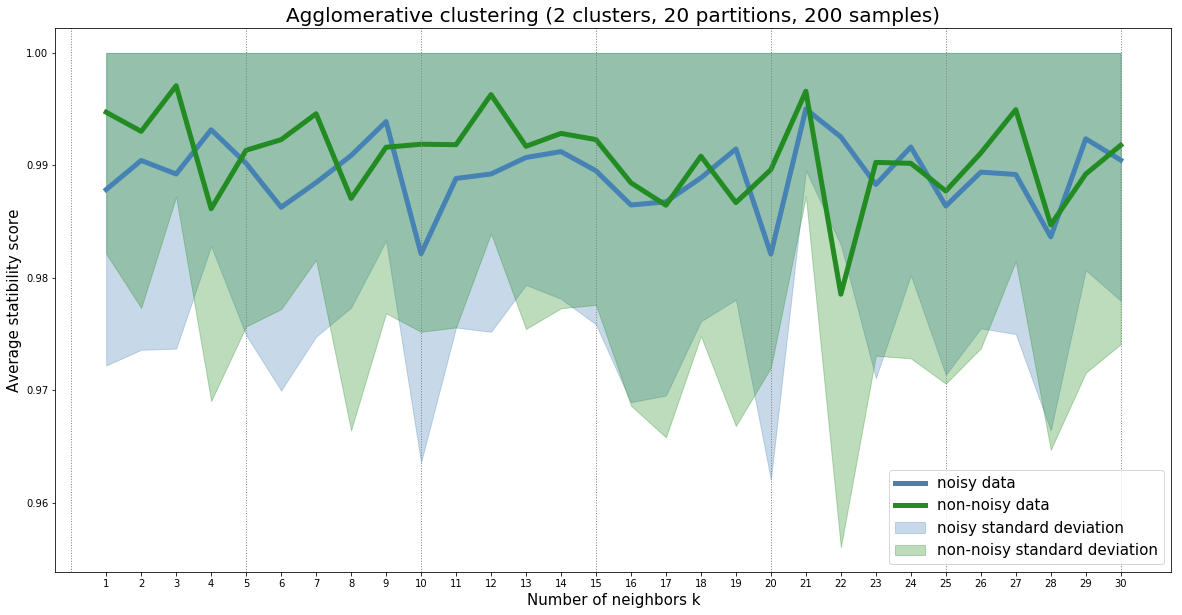

In [17]:
C = 2
B = 20
n_samples = 200
max_k = 30

# clustering algorithm
ac = AgglomerativeClustering(affinity="cosine",
                             linkage="average")
title = "Agglomerative clustering (%i clusters, %i partitions, %i samples)" % (C, B, n_samples)
    
d_non_noisy, d_noisy = stability_test(ac, B, C, n_samples, .05, .2, max_k, precomputed=False)
plot_stability(d_non_noisy, d_noisy, title)

#### Comment: 

Agglomerative cluster has a “rich get richer” behavior that leads to uneven cluster sizes. Therefore, we prefer 'average' linkage to 'complete' linkage. Ward is not available with a non-euclidean affinity. The Agglomerative clustering presents a fair level of stability (but a higher variance) with both noisy and non-noisy datasets. Using average linkage and cosine metric, the number of neighbors has no impact. Unlike with the spectral clustering, there is no quasi-perfect stability for some k values.

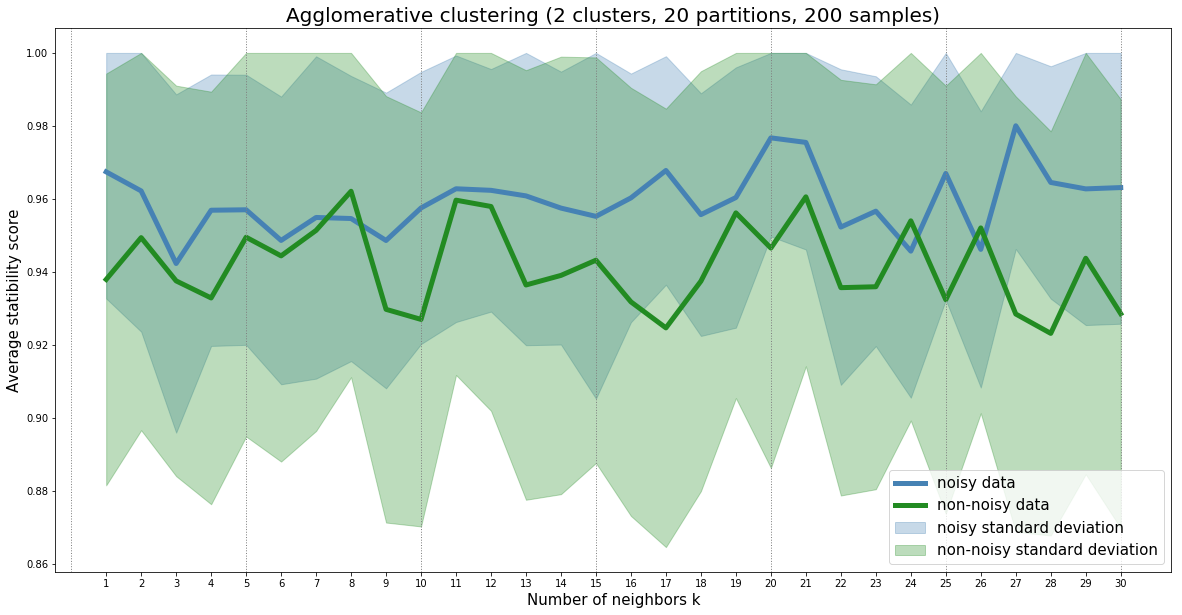

In [18]:
C = 2
B = 20
n_samples = 200
max_k = 30

# clustering algorithm
ac = AgglomerativeClustering(affinity="euclidean",
                             linkage="ward")
title = "Agglomerative clustering (%i clusters, %i partitions, %i samples)" % (C, B, n_samples)
    
d_non_noisy, d_noisy = stability_test(ac, B, C, n_samples, .05, .2, max_k, precomputed=False)
plot_stability(d_non_noisy, d_noisy, title)

#### Comment:

The defaut setup (euclidean affinity and ward linkage) shows a slightly lower stability for both datasets.

/home/arthur/miniconda3/lib/python3.6/site-packages/sklearn/cluster/hierarchical.py:193: UserWarning: the number of connected components of the connectivity matrix is 57 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')
/home/arthur/miniconda3/lib/python3.6/site-packages/sklearn/cluster/hierarchical.py:193: UserWarning: the number of connected components of the connectivity matrix is 48 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')
/home/arthur/miniconda3/lib/python3.6/site-packages/sklearn/cluster/hierarchical.py:193: UserWarning: the number of connected components of the connectivity matrix is 51 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')
/home/arthur/miniconda3/lib/python3.6/site-packages/sklearn/cluster/hierarchical.py:193: UserWarning: the number of connected components of the connectivity matrix is 49 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')
/home/arthur

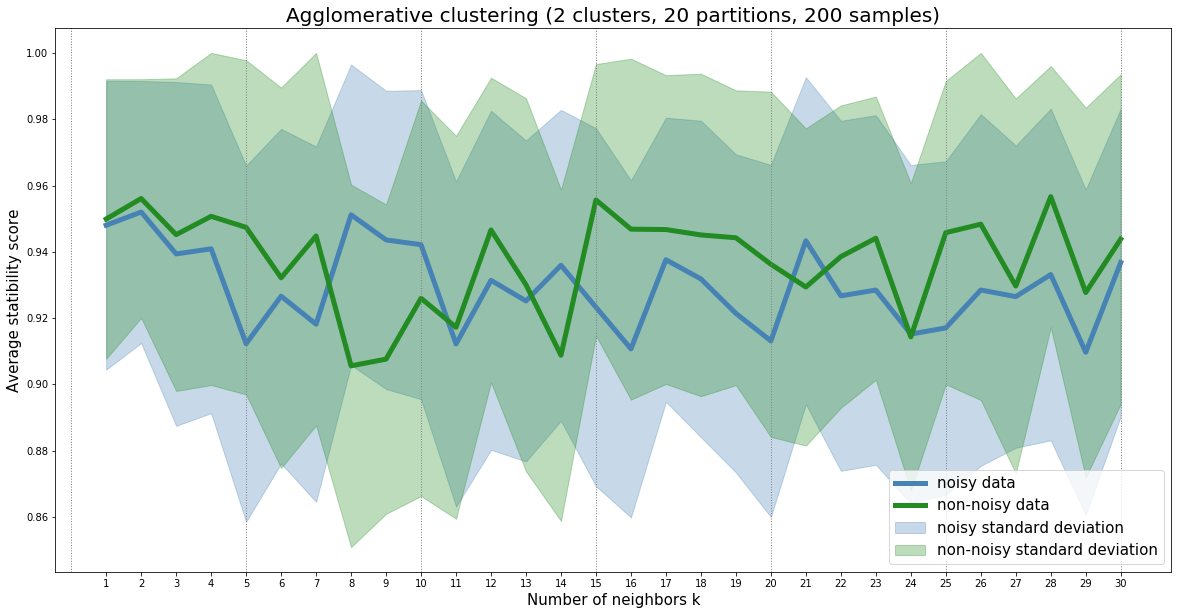

In [19]:
C = 2
B = 20
n_samples = 200
max_k = 30

# clustering algorithm
ac = AgglomerativeClustering(affinity="euclidean",
                             linkage="ward")
title = "Agglomerative clustering (%i clusters, %i partitions, %i samples)" % (C, B, n_samples)
    
d_non_noisy, d_noisy = stability_test(ac, B, C, n_samples, .05, .2, max_k, precomputed="connectivity")
plot_stability(d_non_noisy, d_noisy, title)

#### Comment:

The Agglomerative clustering still presents less stability (and a higher variance) with both noisy and non-noisy datasets in the case of default setup with precomputed affinity matrix. The parameter k does not seem to have any relevant influence on the stability, excepted for the non-noisy data.

### Question 8 : Experiment on MNIST

In [20]:
# Add your code here

In [21]:
from sklearn.datasets import load_digits
from collections import defaultdict
from sklearn.model_selection import StratifiedShuffleSplit

digits = load_digits()
X = digits.data
y = digits.target
print(X.shape)
print(y.shape)

(1797, 64)
(1797,)


In [22]:
for i in set(y):
    r = y[y==i].size * 100 / y.size
    print("label %i: %i samples => %0.1f%%" % (i, y[y==i].size, r))

label 0: 178 samples => 9.9%
label 1: 182 samples => 10.1%
label 2: 177 samples => 9.8%
label 3: 183 samples => 10.2%
label 4: 181 samples => 10.1%
label 5: 182 samples => 10.1%
label 6: 181 samples => 10.1%
label 7: 179 samples => 10.0%
label 8: 174 samples => 9.7%
label 9: 180 samples => 10.0%


The MNIST dataset is already stratified.

In [23]:
def stability_2(clustering_algo, l_partitions, C, knn_full, knn_partitions): 
    """
    clustering_algo: algorithm to test
    l_partitions: list of partitions index
    B: number of bootstrap
    C: number of clusters
    knn_full: knn fit on the entire dataset
    knn_partitions: list of knn fit on the partitions
    """
    clustering_algo.n_clusters = C
    
    # we compute the cluster with the entire dataset
    clustering_algo.fit(knn_full)
    y_pred = clustering_algo.labels_
    
    # we build the matrix representation
    M = matrix_representation(y_pred)
    
    # bootstrap
    l_similarity = []
    for i, ix_partition in enumerate(l_partitions):
        # we compute the cluster with the partition
        knn_partition = knn_partitions[i]
        clustering_algo.fit(knn_partition)
        y_pred = clustering_algo.labels_
        
        # we build the matrix representation
        M_partition = matrix_representation(y_pred)
        
        # we compute the similarity between matrix representations
        similarity = cosine_similarity(M[ix_partition[:, None], ix_partition], M_partition)
        l_similarity.append(similarity)
    
    return l_similarity

#### Note: the following cells takes a long time to run

In [24]:
# setup
B = 20
max_k = 30
l_C = [i for i in range(2, 15, 2)]

# clustering algorithm
sc = SpectralClustering(random_state=13, 
                        affinity="precomputed", 
                        eigen_solver="arpack")

# datasets
digits = load_digits()
X = digits.data
y = digits.target
    
sss = StratifiedShuffleSplit(n_splits=B, train_size=0.8, test_size=0.2, random_state=13)

# we list all our partitions
l_X_partitions = []
l_partitions = []
for train_index, test_index in sss.split(X, y):
    X_partition = X[train_index, :]
    l_X_partitions.append(X_partition)
    l_partitions.append(train_index)

# for each value of k we precompute a nearest neighbors with the entire dataset and the partitions
print("computing knn with...")
d_k = defaultdict(lambda: [])
d_k_full = {}
for k in range(2, max_k + 1, 2):
    print("...k = %i" % k)
    # entire dataset
    kn = kneighbors_graph(X, n_neighbors=k, include_self=False)
    sim_kn = (kn + kn.T) / 2
    d_k_full[k] = sim_kn
    # partitions
    for X_partition in l_X_partitions:
        kn = kneighbors_graph(X_partition, n_neighbors=k, include_self=False)
        sim_kn = (kn + kn.T) / 2
        d_k[k].append(sim_kn)
print()

# for each value of C and k we compute B stability measures
d_C = defaultdict(lambda: {})
print("computing stability with...")
for C in l_C:
    print("...C = %i" % C)
    for k in range(2, max_k + 1, 2):
        knn_full = d_k_full[k]
        knn_partitions = d_k[k]
        # stability measures
        stability_Ck = stability_2(clustering_algo=sc, 
                                   l_partitions=l_partitions, 
                                   C=C, 
                                   knn_full=knn_full, 
                                   knn_partitions=knn_partitions)
        d_C[C][k] = stability_Ck
print("---------------------------")

computing knn with...
...k = 2
...k = 4
...k = 6
...k = 8
...k = 10
...k = 12
...k = 14
...k = 16
...k = 18
...k = 20
...k = 22
...k = 24
...k = 26
...k = 28
...k = 30

computing stability with...
...C = 2


/home/arthur/miniconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


...C = 4
...C = 6
...C = 8
...C = 10
...C = 12
...C = 14
---------------------------


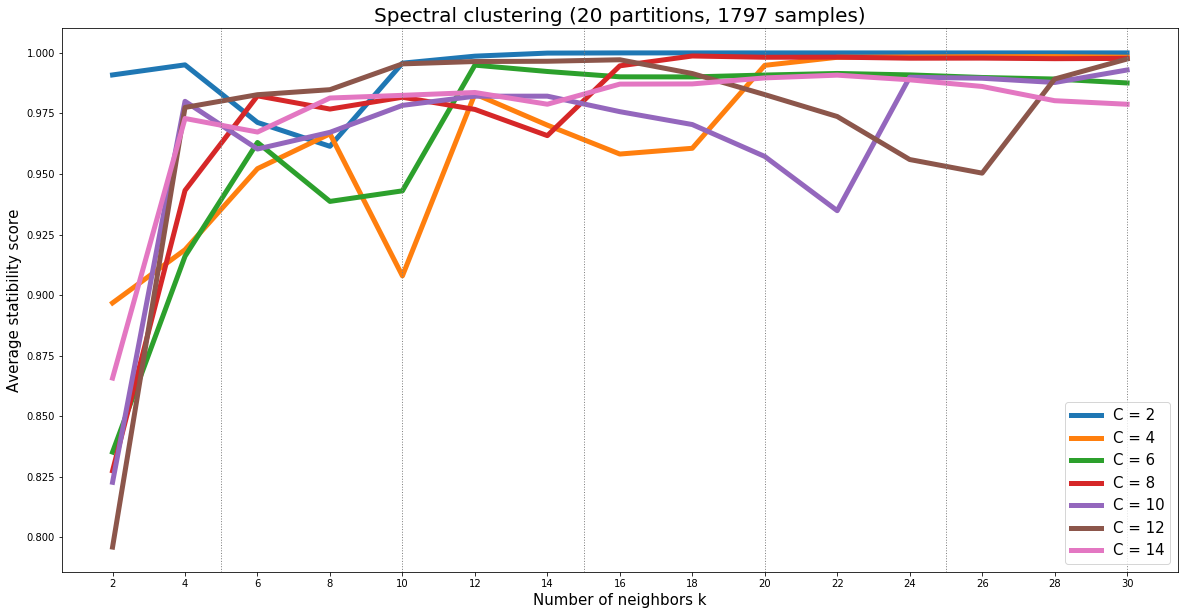

In [25]:
# plot
title = "Spectral clustering (%i partitions, %i samples)" % (B, X.shape[0])
plt.figure(figsize=(20, 10))
x = [k for k in range(2, max_k + 1, 2)]
    
for C in l_C:
    y = []
    y_up = []
    y_low = []
        
    for k in range(2, max_k + 1, 2):
        m = np.mean(d_C[C][k])
        sd = np.std(d_C[C][k])
        y.append(m)
        y_up.append(min(m + sd, 1))
        y_low.append(m - sd)
        
    #plt.fill_between(x, y_low, y_up, alpha=0.3)
    plt.plot(x, y, label="C = %i" % C, linewidth=5)        

for k in range(5, max_k + 1, 5):
    plt.axvline(x=k, ymin=0, ymax=2, linewidth=1, color='gray', linestyle=":")
plt.legend(loc="lower right", prop={'size': 15})
plt.xlabel("Number of neighbors k", fontsize=15)
plt.ylabel("Average statibility score", fontsize=15)
plt.title(title, fontsize=20)
plt.xticks(x, x)
plt.show()

#### Comment:

The stability doesn't seem to be relevant to determine an optimal C. The later could be define by a transition from a high level of stability to a lower level of stability with more variance. For some cases, the transition isn't obvious. For example, if a cluster breaks into two clusters, a large one and a small one, the stability won't be dramatically impacted.

In [26]:
# we define functions to compute the eigengap process
def compute_eigenvalues(X, n, k):
    
    # compute adjacency and degree matrices
    kn = kneighbors_graph(X, n_neighbors=k, include_self=False)
    W = (kn + kn.T) / 2
    W[W > 0] = 1
    W = W.todense()
    D = np.zeros((n, n))
    for i in range(n):
        D[i, i] = W[i, :].sum()

    # compute the normalized Graph Laplacian and its eigenvalues
    L = D - W
    L_norm = np.linalg.solve(D, L)
    eigenvalues = sorted(np.linalg.eigvals(L_norm))
    
    return eigenvalues


def plot_eigenvalues(eigenvalues, title):
    
    # plot the first eigenvalues
    plt.figure(figsize=(10, 5))
    x = [i + 1 for i in range(len(eigenvalues[:20]))]
    plt.scatter(x, eigenvalues[:20], s=30, color="steelblue", marker="D")        
    plt.title(title, fontsize=20)
    plt.xticks(x, x)
    plt.show()
    
    return

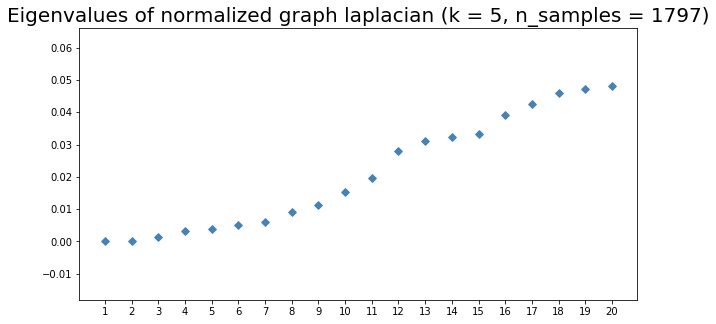

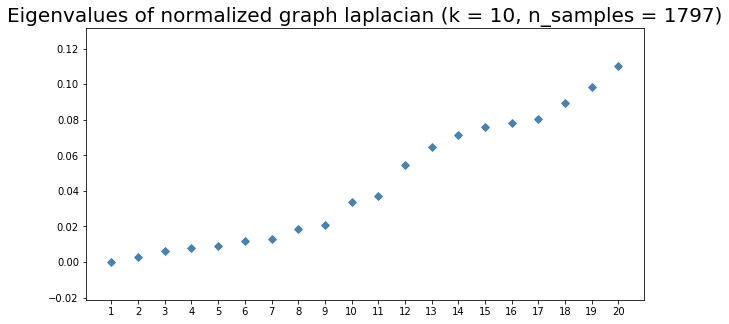

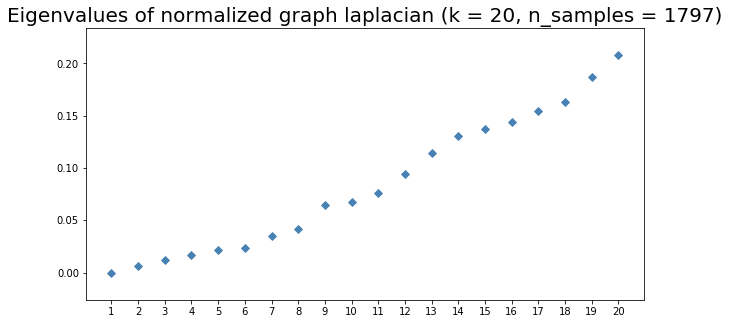

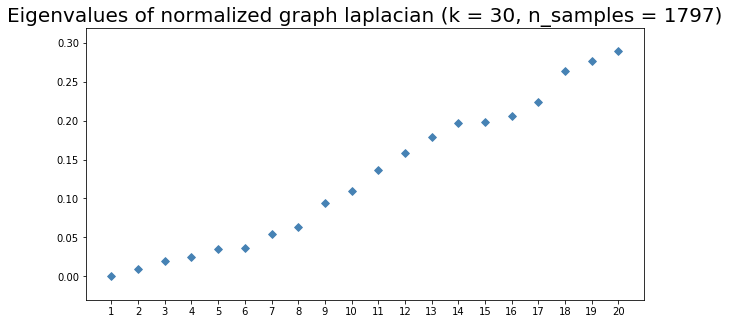

In [27]:
# datasets
digits = load_digits()
X = digits.data
n = X.shape[0]

for k in [5, 10, 20, 30]:
    # eigenvalues
    eigenvalues = compute_eigenvalues(X, n, k)
    # plot
    title = "Eigenvalues of normalized graph laplacian (k = %i, n_samples = %i)" % (k, n)
    plot_eigenvalues(eigenvalues, title)

#### Comment:

According to the eigengap procedure, the optimal C should be between 9 (k high) and 12 (k low).

## Semi-Supervised Learning

Choice of the dataset used : **Precise** which dataset you chose and why it is relevant for the semi-supervised learning Task

Advised datasets :

*Breast Cancer Wisconsin (Diagnostic) Database*

*MNIST binary even vs odd (multiple clusters inside each class)*

Feel free to use other datasets if they are relevant

### Question 9 : Complete the code in the box below

In [28]:
from sklearn.datasets import load_breast_cancer, load_digits
from sklearn.model_selection import train_test_split


### For all the next questions, use Cancer and Mnist classes to handle your data if you choose to use these one,
### You can also add more datasets but we advise you to handle them with this class for better readability
class semi_sup_dat:
    def __init__(self,data, p_unlabelled, name):
        # DON T CHANGE THE RANDOM STATES
        self.name = name
        if self.name == 'Mnist':
            # do an even vs odd binary classification :
            even = [0,2,4,6,8]
            Y = [int(y in even) for y in data.target]
        else:
            Y = data.target
        X_lab, X_unlab, y_lab, y_unlab = train_test_split(data.data, data.target, test_size=p_unlabelled, random_state=32)
        self.X_lab = X_lab
        self.X_unlab = X_unlab
        self.y_lab = y_lab
        self.y_unlab = y_unlab


# The following lines can be called later in the code to build a dataset with varying unlabelled proportion
p_unlabelled = 0.7 # You can change this value
Cancer = semi_sup_dat(load_breast_cancer(), p_unlabelled,'Cancer')
digits = load_digits()
Mnist = semi_sup_dat(load_digits(), p_unlabelled,'Mnist')

#### Comment:

We choose the Breast Cancer Wisconsin Database which has 569 observations. It is a binary classification problem; the classes correspond to the diagnostic (malignant or benign).

This dataset is relevant for the semi-supervised learning (SSL) task since the SSL assumptions are very likely to be met:
- if two input points in a high density region are close, then so should be the corresponding y_1 and y_2 (smoothness assumption),
- if two input points are close, they belong to the same class (cluster assumption),
- the data roughly lie in a low-dimensional manifold (manifold assumption).

In [29]:
# Get the Toy data
noisy_moons = make_moons(n_samples=n_samples, noise=0.05)
X, y = noisy_moons
class moons(object):
    pass
moons.data = X
moons.target = y
p_unlabelled = 0.7 # You can change this value
Moons = semi_sup_dat(moons, p_unlabelled, 'Moons')

### Question 10 : Complete the code in the box below

In [30]:
#  Question 10  : Complete the function self_training
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd  
from sklearn.decomposition import PCA

def self_training(data, n_neighbors=5, kmax=50):
    """
    We reproduce the algorithm seen in Lecture 7.
    We define the most confident labels as the predictions with class probabilities equal to 1 or 0.
    By default we use n_neighbors=5, this value can be changed.
    """
    X_lab = data.X_lab
    y_lab = data.y_lab 
    X_unlab = data.X_unlab
    y_unlab = data.y_unlab

    classifier = KNeighborsClassifier(n_neighbors)

    k = 0
    S = [X_lab, y_lab]
    X_unlab2 = X_unlab
    
    # learn f by training on S (labelled data)
    classifier.fit(S[0], S[1])

    while (len(X_unlab2) > 0 and k < kmax):

        # Use f to label the unlabelled data
        y_unlab_pred = classifier.predict(X_unlab2)

        # Get the subsample D which contains the most confident labels  -- D contains the new labelled data 
        y_unlab_proba = classifier.predict_proba(X_unlab2)   
        y_unlab_proba = pd.DataFrame(y_unlab_proba) 
        if k == kmax - 1 or len(X_unlab2) < 1 :
            D = y_unlab_proba # For the last iteration, we do not use the confidence criterion
        else:
            D = y_unlab_proba[y_unlab_proba[0]==0 | (y_unlab_proba[0]==1)] # confidence criterion

        # Update the labelled data
        S[0] = np.concatenate((S[0], X_unlab[D.index]))
        S[1] = np.concatenate((S[1], y_unlab_pred[D.index]))
        
        # Update the unlabelled data
        X_unlab2 = [y for x,y in enumerate(X_unlab2) if x not in D.index]
        X_unlab2 = np.array(X_unlab2)

        # Learn f by training on S
        classifier.fit(S[0], S[1])
        
        k = k + 1 
        
        if len(X_unlab2) == 0 :
            print("%i iterations needed to label y_unlab" %k)
        
    return S


def plot_semisupervised(X, y_predict, y, title_predict, title, acp=False):
    
    fig = plt.figure(figsize=(15, 5))
    
    if acp:
        pca = PCA(n_components=2)
        X = pca.fit_transform(X)
    
    # plot y_predict
    ax0 = plt.subplot2grid((1, 2), (0, 0))
    ax0.set_facecolor('white')
    ax0.scatter(X[y_predict == 1][:,0], X[y_predict == 1][:,1], color="orange", alpha=0.8, label="y predicted = 1")
    ax0.scatter(X[y_predict == 0][:,0], X[y_predict == 0][:,1], color="forestgreen", alpha=0.8, label="y predicted = 0")
    plt.legend()

    # plot true y
    ax1 = plt.subplot2grid((1, 2), (0, 1))
    ax1.set_facecolor('white')
    ax1.scatter(X[y == 1][:,0], X[y == 1][:,1], color="orange", alpha=0.8, label="true y = 1")
    ax1.scatter(X[y == 0][:,0], X[y == 0][:,1], color="forestgreen", alpha=0.8, label="true y = 0")
    
    plt.legend()
    
    if acp:
        ax0.set_xlabel("First component", fontsize=15)
        ax0.set_ylabel("Second component", fontsize=15)
        ax1.set_xlabel("First component", fontsize=15)
        ax1.set_ylabel("Second component", fontsize=15)
    else:
        ax0.set_xlabel("X1", fontsize=15)
        ax0.set_ylabel("X2", fontsize=15)
        ax1.set_xlabel("X1", fontsize=15)
        ax1.set_ylabel("X2", fontsize=15)
    
    ax0.set_title(title_predict, fontsize=15)
    ax1.set_title(title, fontsize=15)

    plt.tight_layout()
    plt.show()
    
    return

In [31]:
# Test the self training algorithm
from sklearn.metrics import accuracy_score
S = self_training(Moons)

y_total = np.concatenate([Moons.y_lab, Moons.y_unlab])
error_rate = np.linalg.norm(S[1] - y_total , 1) / len(y_total)
print( "Error rate (Toy dataset):", error_rate)
print( "Accuracy (Toy dataset): " , accuracy_score(y_total, S[1]) )

2 iterations needed to label y_unlab
Error rate (Toy dataset): 0.33
Accuracy (Toy dataset):  0.67


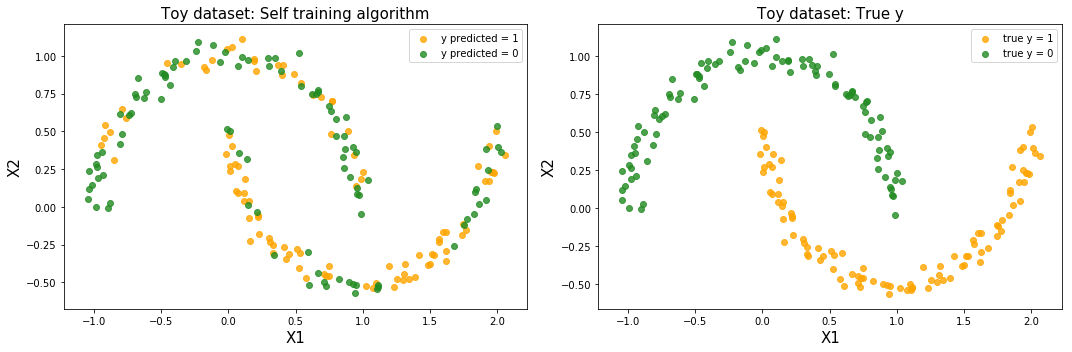

In [32]:
X = np.concatenate([Moons.X_lab, Moons.X_unlab])
y = np.concatenate([Moons.y_lab, Moons.y_unlab])
y_predict = S[1]
title1 = "Toy dataset: Self training algorithm"
title2 = "Toy dataset: True y"
plot_semisupervised(X, y_predict, y, title1, title2)

In [33]:
# Apply to the chosen dataset 
S = self_training(Cancer)
y_total = np.concatenate([Cancer.y_lab, Cancer.y_unlab])
print( "Accuracy (Cancer dataset): " , accuracy_score(y_total, S[1]) )

50 iterations needed to label y_unlab
Accuracy (Cancer dataset):  0.66783831283



**Note:** For the Cancer dataset, we plot the data projected on the 2 first principal components of a PCA.

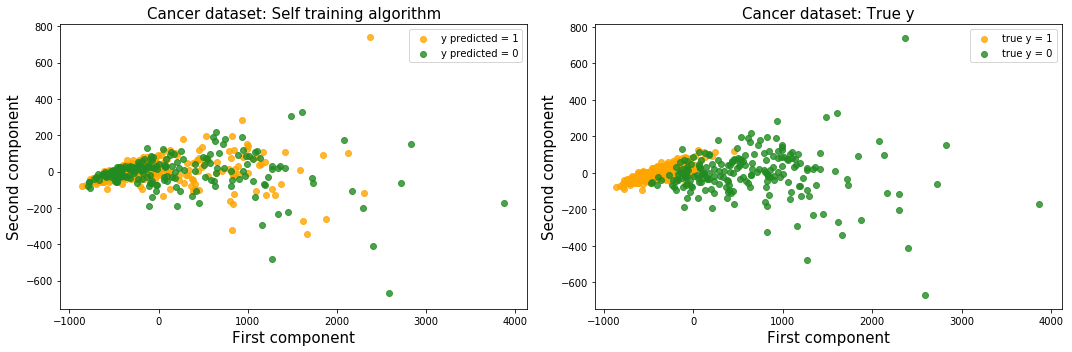

In [34]:
X = np.concatenate([Cancer.X_lab, Cancer.X_unlab])
y = np.concatenate([Cancer.y_lab, Cancer.y_unlab])
y_predict = S[1]
title1 = "Cancer dataset: Self training algorithm"
title2 = "Cancer dataset: True y"
plot_semisupervised(X, y_predict, y, title1, title2, acp=True)

#### Comment:

The results of the self-training algorithm are so-so (accuracy = 0.67 with the Cancer dataset). We need a more robust approach.

### Question 11 : Complete the code in the box below



###### Closed form expression :

We want to solve $\underset{f \in H_{k}}{min} \frac{1}{l} \sum_{i=1}^l (y_{i} − f(x_{i} ))^2 + \lambda || f ||_{H_{k}}^2 + \frac{\lambda_{u}}{(u+l)^2} f^{T} L  f$. 


The representer theorem implies the solution admits an expansion in the following terms:

$$f^{*}(x) = \sum_{i=1}^{l+u} \alpha_{i}^{*} K(x,x_{i}).$$


Hence we can write: 

- $ \sum_{i=1}^l(y_i-f(x_i))^2 = \sum_{i=1}^l(y_i-\sum_{j=1}^{l+u}\alpha_j K(x_i,x_j))^2 = (Y-JK\alpha)^T(Y-JK\alpha)$

- $ ||f||_{H_{k}}^2 = \left \langle \sum_{i=1}^{l+u}\alpha_iK(.,x_i), \sum_{j=1}^{l+u}\alpha_jK(.,x_j)\right \rangle_{H_{k}} = \alpha^T K \alpha $ 

-  $ f^{T} L f = \alpha ^T K^T L K \alpha $ 

The minimization problem becomes : $ \alpha^* = \underset{\alpha \in R^{l+u}}{argmin}  \frac{1}{l} (Y-JK\alpha)^T(Y-JK\alpha)  + \lambda
\alpha^T K \alpha + \frac{\lambda_{u}}{(u+l)^2} \alpha ^T K^T L K \alpha $.

This is a convex differentiable objective function. The derivative vanishes at the minimizer. Hence, the closed form expression is:
$$
 \alpha^* = (JK + \lambda l \mathbb{1} + \frac{\lambda_u l }{(u+l)^2} LK)^{-1}Y 
$$


With $J$ a diagonal matrix with the first $l$ values equal to 1 and the remaining ones to 0, $K$ the Gram matrix over labeled and unlabeled points and $L$ the Laplacian of the data graph.


****


In practice, we take a constant function added to the function of the RKHS: $ g_{\alpha^*,b}(x) = f_{\alpha^*}(x) + b $. 
The problem then becomes:  $$ \underset{\alpha, b}{min}  \frac{1}{l} (Y-JK\alpha - bJ\mathbb{1})^T(Y-JK\alpha-bJ\mathbb{1})  + \lambda
\alpha^T K \alpha + \frac{\lambda_{u}}{(u+l)^2} \alpha ^T K^T L K \alpha .$$  

Solving the minimization problem in $\alpha$ gives: 
$ \alpha^* = (JK + \lambda l \mathbb{1} + \frac{\lambda_u l }{(u+l)^2} LK)^{-1} (Y - b^*\mathbb{1}) $ 

Solving the minimization problem in $b$ gives: 
$ b^* = \frac{1}{l}(Y-J K \alpha^*) $ 

Substituting $ b^* $ in $ \alpha^* $ and $ \alpha^* $ in $ b^* $  gives also a closed form expression.




### Question 12 : Add your answer here

In [35]:
from sklearn.metrics.pairwise import rbf_kernel # Or reimplement it yourself if your prefer
from scipy.linalg import block_diag

In [36]:
def LapRLS(data, n_neighbors=5, lbda=0.01, lbda_u=0.001):
    """
    We implement the algorithm developped by Belkin et al. (2006)
    """
    X_lab = data.X_lab
    y_lab = data.y_lab 
    X_unlab = data.X_unlab
    y_unlab = data.y_unlab

    u = len(X_unlab)
    l = len(X_lab)
    n = u + l 

    # J matrix 
    J = np.eye(n)
    J[l:] = 0 

    # Y matrix
    Y = np.zeros(n)
    Y[0:l] = y_lab

    # step 1. data adjency graph with (l+u) nodes using k nearest neighbors
    X_total = np.concatenate([X_lab, X_unlab])
    kn = kneighbors_graph(X_total, n_neighbors=n_neighbors, include_self=False)
    W = (kn + kn.T) / 2
    W[W > 0] = 1
    W = W.todense()

    # step 2. compute the Gram Matrix
    K = rbf_kernel(X_total)

    # step 3. comput graph Laplacian Matrix
    D = np.zeros((n, n))
    for i in range(n):
        D[i, i] = W[i, :].sum()
    L = D - W                    

    # step 4. choose the regularization parameters   
    lbda = lbda
    lbda_u = lbda_u

    # step 5. compute alpha*
    need_inv = J.dot(K) + lbda * l * np.identity(n) + lbda_u * l / (u+l)**2 * L.dot(K)
    alpha_star = np.linalg.inv(need_inv).dot(Y).T
    
    # step 6. ouput function f*(x)
    f = np.dot(K[:, :], alpha_star)
    f = np.ravel(f).T
    
    return f


def plot_continuous_predict(X_total, pred, lbda, accuracy=False, acp=False):
    if acp:
        pca = PCA(n_components=2)
        X_total = pca.fit_transform(X_total)        
    fig, ax = plt.subplots(figsize=(8, 5))
    plt.scatter(X_total[:, 0], X_total[:, 1], c=pred)
    if not accuracy:
        ax.set_title("Toy dataset (lambda_u=%.03f)" % lbda,  fontsize=15)
    else:
        ax.set_title("lambda_u=%.04f and accuracy=%.02f " % (lbda, accuracy), fontsize=15)
    plt.colorbar()
    plt.legend()
    plt.tight_layout()
    return

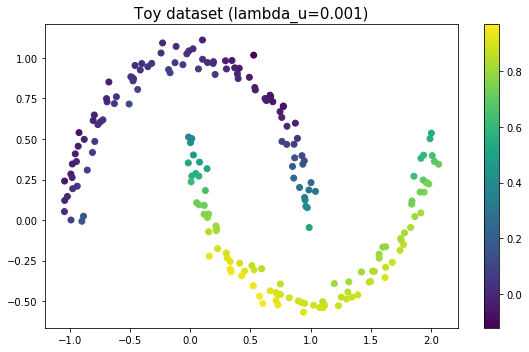

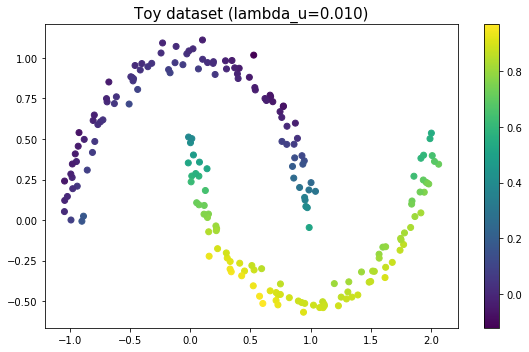

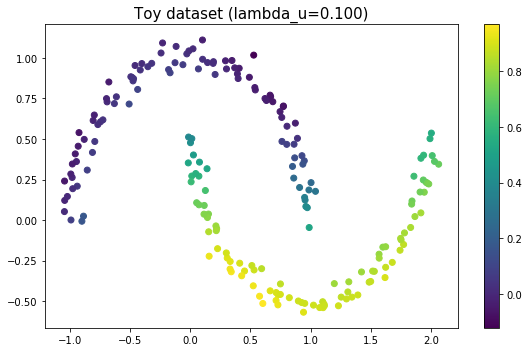

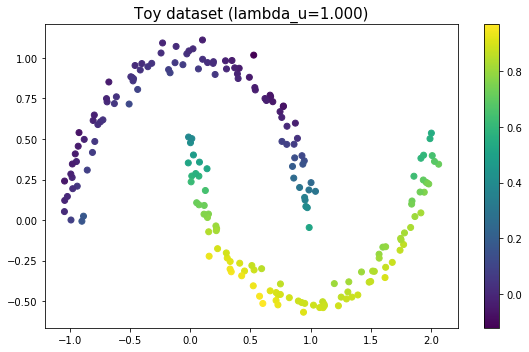

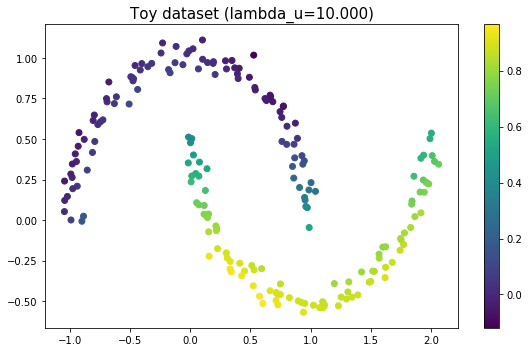

In [37]:
# Toy dataset
X_total = np.concatenate([Moons.X_lab, Moons.X_unlab])
lbda_u_list = [0.001, 0.01, 0.1, 1, 10]

for lbda_u in lbda_u_list:
    pred= LapRLS(Moons, n_neighbors=5, lbda=0.01, lbda_u=lbda_u)
    plot_continuous_predict(X_total, pred, lbda_u)

We need to define a threshold such that our labels are 1 or 0. 
We take a threshold equal to the median of the labels:

$y_i = 1 $ if $y_i > median(y)$, otherwise $y_i = 0 $. 

In [38]:
def threshold_label(y_continue):
    mediane = np.median(y_continue)
    y_discret = np.zeros(len(y_continue))
    for i in range(len(y_continue)):
        if y_continue[i] > mediane:
            y_discret[i] = 1
    return y_discret

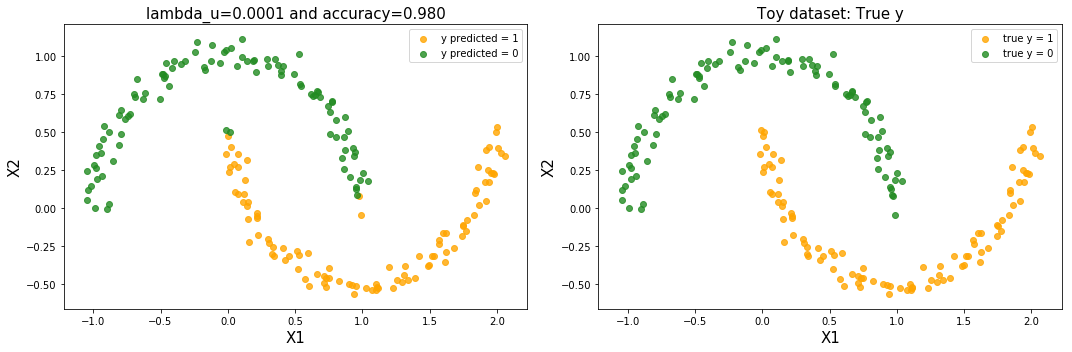

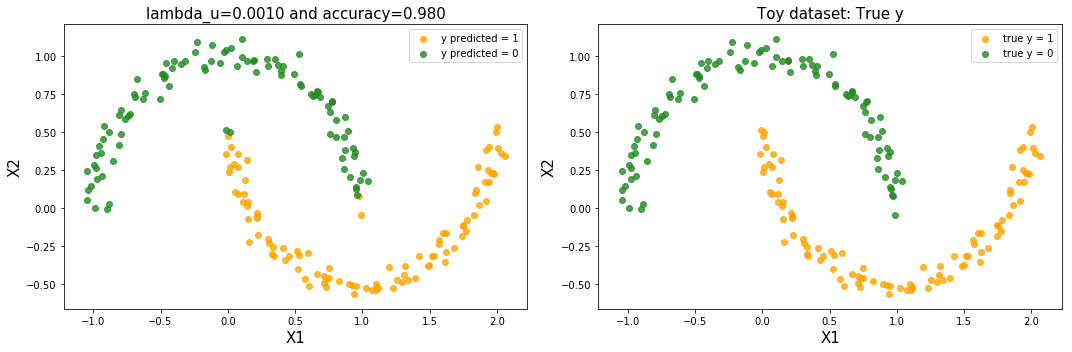

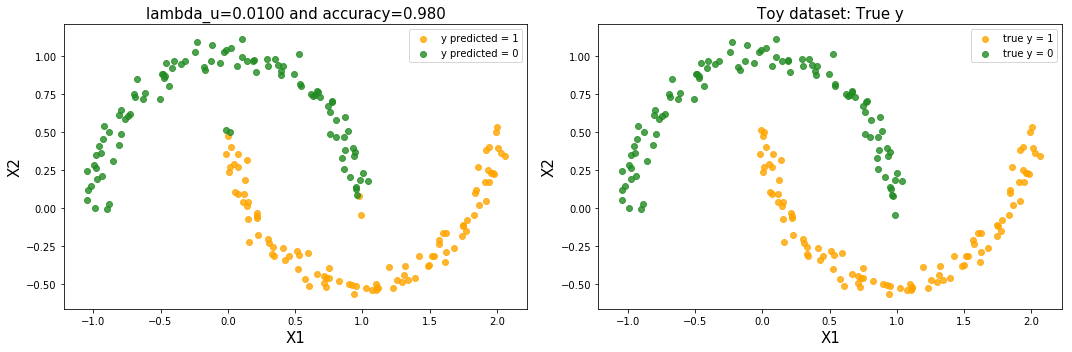

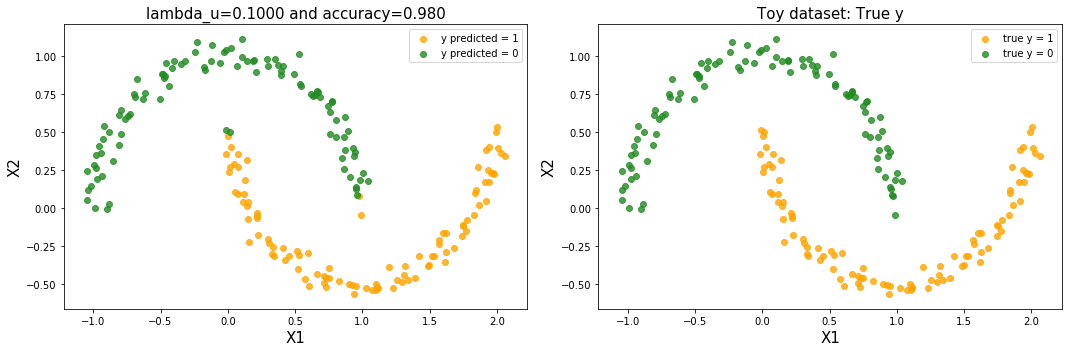

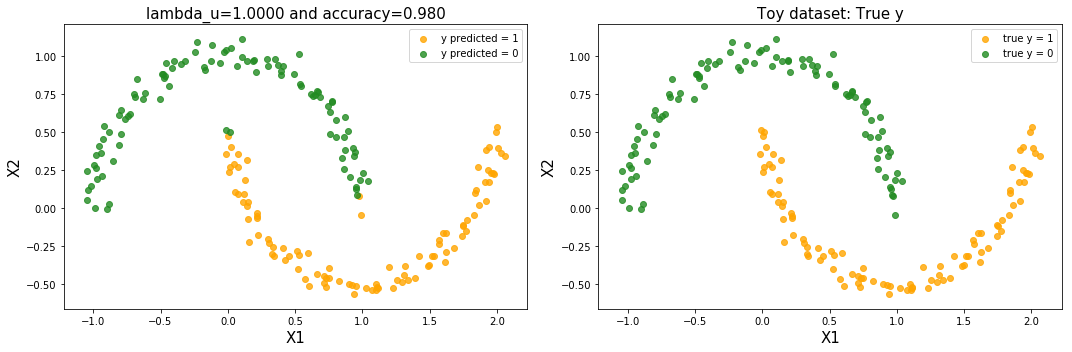

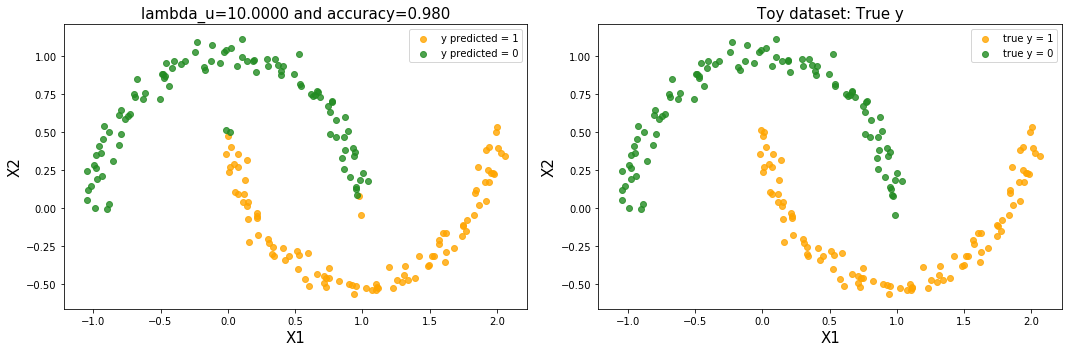

In [39]:
# Toy dataset
X_total = np.concatenate([Moons.X_lab, Moons.X_unlab])
y_total = np.concatenate([Moons.y_lab, Moons.y_unlab])
lbda_u_list = [0.0001, 0.001, 0.01, 0.1, 1, 10]
error_rate_toy = []

for lbda_u in lbda_u_list:
    y_continue = LapRLS(Moons, n_neighbors=5, lbda=0.01, lbda_u=lbda_u)
    pred = threshold_label(y_continue=y_continue)
    accuracy = accuracy_score(y_total, pred)
    error_rate_toy.append(np.linalg.norm(pred - y_total , 1) / len(y_total))
    title1 = "lambda_u=%.04f and accuracy=%.03f" % (lbda_u, accuracy)
    title2 = "Toy dataset: True y"
    plot_semisupervised(X_total, pred, y_total, title1, title2)

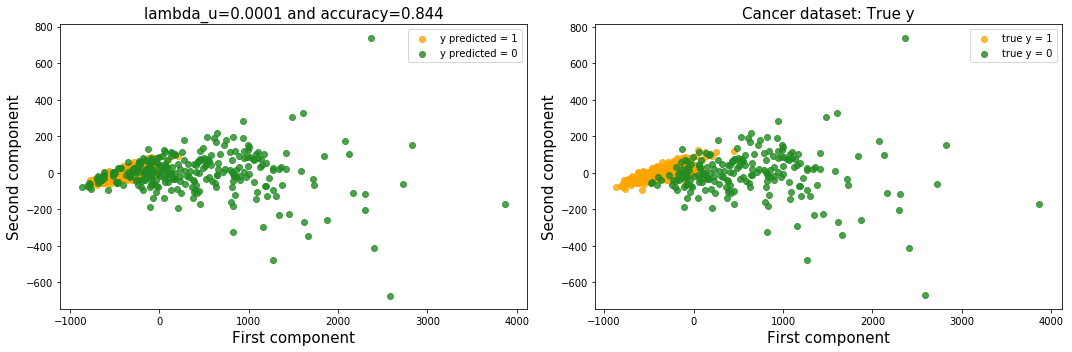

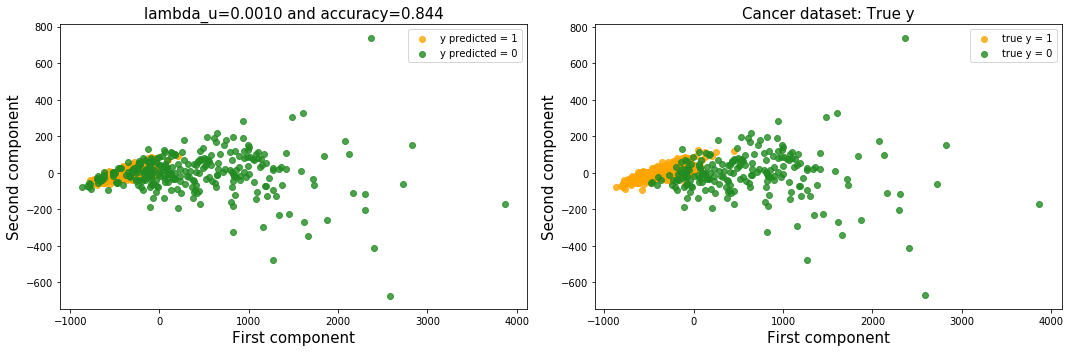

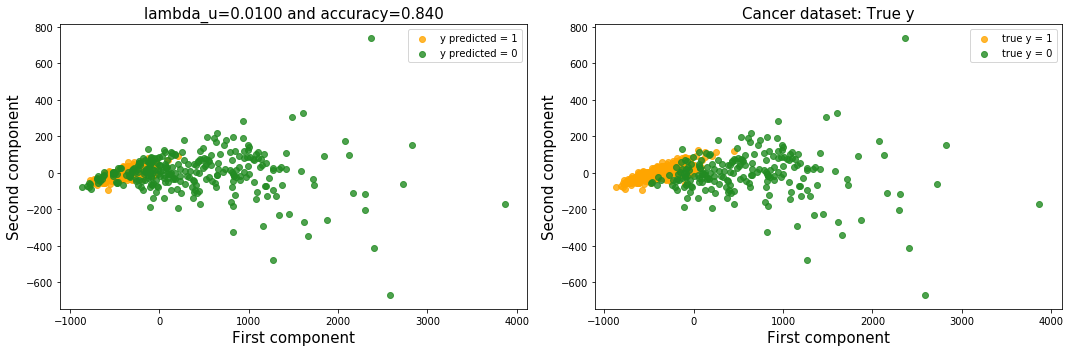

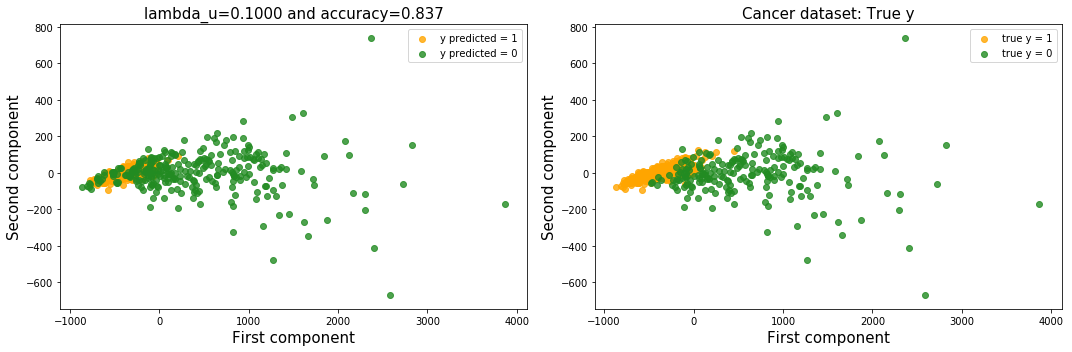

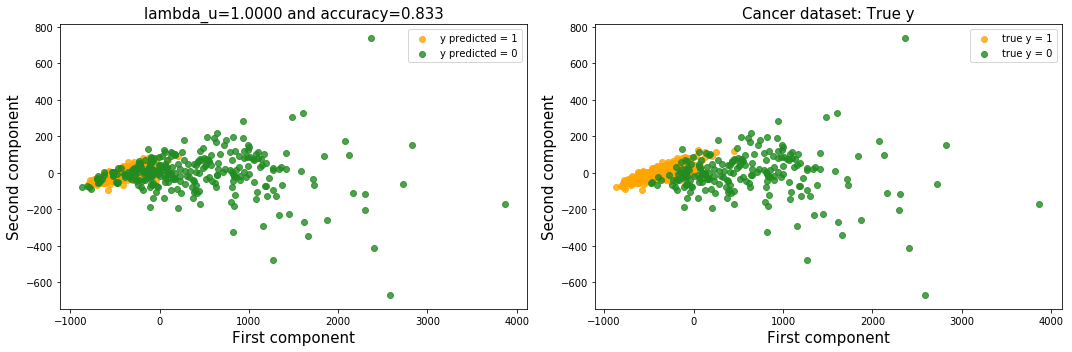

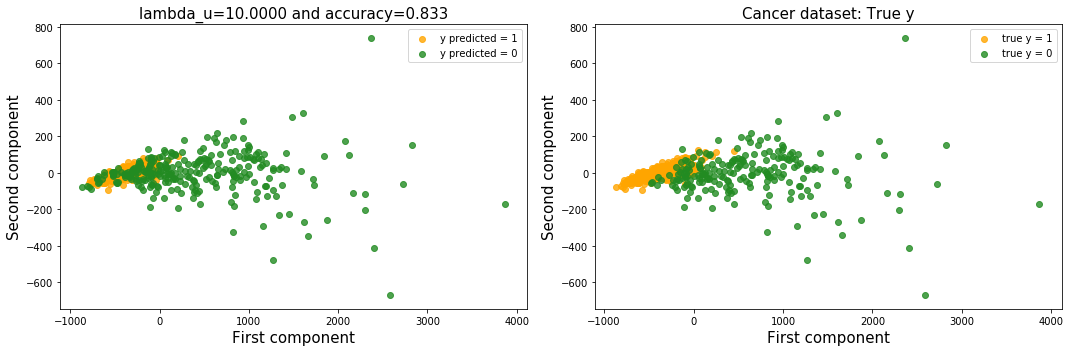

In [40]:
# Chosen dataset
X_total = np.concatenate([Cancer.X_lab, Cancer.X_unlab])
y_total = np.concatenate([Cancer.y_lab, Cancer.y_unlab])
error_rate_cancer = []

for lbda_u in lbda_u_list:
    y_continue = LapRLS(Cancer, n_neighbors=5, lbda=0.01, lbda_u=lbda_u)
    pred = threshold_label(y_continue=y_continue)
    accuracy = accuracy_score(y_total, pred)
    error_rate_cancer.append(np.linalg.norm(pred - y_total , 1) / len(y_total))    
    title1 = "lambda_u=%0.04f and accuracy=%0.03f" % (lbda_u, accuracy)
    title2 = "Cancer dataset: True y"
    plot_semisupervised(X_total, pred, y_total, title1, title2, acp=True)

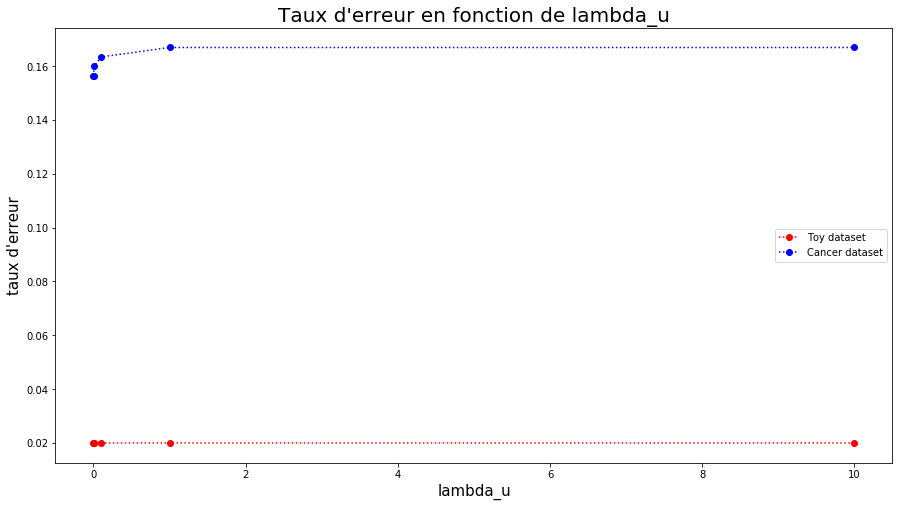

In [41]:
fig = plt.figure(1, figsize=(15, 8)) 
plt.plot(lbda_u_list, error_rate_toy, "r:o", label="Toy dataset")
plt.plot(lbda_u_list, error_rate_cancer, "b:o", label="Cancer dataset")
plt.legend()
plt.title("Taux d'erreur en fonction de lambda_u", fontsize=20)
plt.xlabel("lambda_u", fontsize=15)
plt.ylabel("taux d'erreur", fontsize=15)
plt.show()

#### Comment 

$\lambda_u$ is a regularization parameter used to ensure that the solution is smooth with respect to the marginal distribution PX. Belkin et al. argue that a value of $\lambda_u$ close to 0 is optimal. We observe no significant change when changing the value of $\lambda_u$. 

However we can notice that for the Cancer dataset, the accuracy decreases a little bit as $\lambda_u$ gets larger (84.4 % for $\lambda_u$ = 0.001 against 83.3 % for $\lambda_u$ = 10).


Note that, for both datasets, the accuracy obtained with the LapRLS algorithm is larger than the one obtained with the self-training algorithm.

### Question 13 : Add your answer here

The closed-form solution implementation is:
- expensive to compute in high-dimension (invertion of a matrix of size n!) 
- sometimes impossible (matrix non-invertible).

### Question 14 : Complete the code in the box below

**The SGD approach is as following: **

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.


**We want to solve the following problem using SGD:**

$$  \underset{\alpha \in R^{l+u}}{min} f(\alpha) =  \underset{\alpha \in R^{l+u}}{min}  \frac{1}{l} (Y-JK\alpha)^T(Y-JK\alpha)  + \lambda
\alpha^T K \alpha + \frac{\lambda_{u}}{(u+l)^2} \alpha ^T K^T L K \alpha. $$


We have : $ \nabla f(\alpha) = \frac{-2}{l} K^T J^T (Y-JK\alpha) + 2 \lambda K \alpha + \frac{2 \lambda_u }{(u+l)^2} K^T LK \alpha  $ 

In [42]:
def grad_i(i, alpha2, lbda, lbda_u, l, K, Y, J, u, L):
    L =  np.squeeze(np.asarray(L))
    grad = -2 / l * K[i] * J[i] * (Y[i] - J[i]* K[i] * alpha2) + 2 * lbda * K[i] * alpha2
    grad += 2 * lbda_u / (u+l)**2 * K[i] * L[i] * K[i] * alpha2  
    return grad

In [43]:
def LapRLS_SGD(data, n_neighbors=5, lbda=0.01, lbda_u=0.001):
    """
    We implement the algorithm developped by Belkin et al. (2006) using the SGD method to compute alpha
    """ 
    X_lab = data.X_lab
    y_lab = data.y_lab 
    X_unlab = data.X_unlab
    y_unlab = data.y_unlab

    u = len(X_unlab)
    l = len(X_lab)
    n = u + l 

    # J matrix 
    J = np.eye(n)
    J[l:] = 0 

    # Y matrix
    Y = np.zeros(n)
    Y[0:l] = y_lab
    
    # step 1. data adjency graph with (l+u) nodes using k nearest neighbors
    X_total = np.concatenate([X_lab, X_unlab])
    kn = kneighbors_graph(X_total, n_neighbors=n_neighbors, include_self=False)
    W = (kn + kn.T) / 2
    W[W > 0] = 1
    W = W.todense()

    # step 2. compute the Gram Matrix
    K = rbf_kernel(X_total)

    # step 3. comput graph Laplacian Matrix
    D = np.zeros((n, n))
    for i in range(n):
        D[i, i] = W[i, :].sum()
    L = D - W                    

    # step 4. choose the regularization parameters   
    lbda = lbda
    lbda_u = lbda_u

    # step 5. compute alpha* - SGD method
    n_iter = 50
    step = 1.
   
    iis = np.random.randint(0, n, n * n_iter) # generate indices of random samples
    alpha2 = np.zeros(n)
    for idx in range(n_iter):
        i = iis[idx]
        alpha2 -= (step / (np.sqrt(idx + 1))) * grad_i(i, alpha2, lbda, lbda_u, l, K, Y, J, u, L)
              
    # step 6. ouput function f*(x)
    f = np.dot(K[:, :], alpha2)
    f = np.ravel(f).T
    
    return f

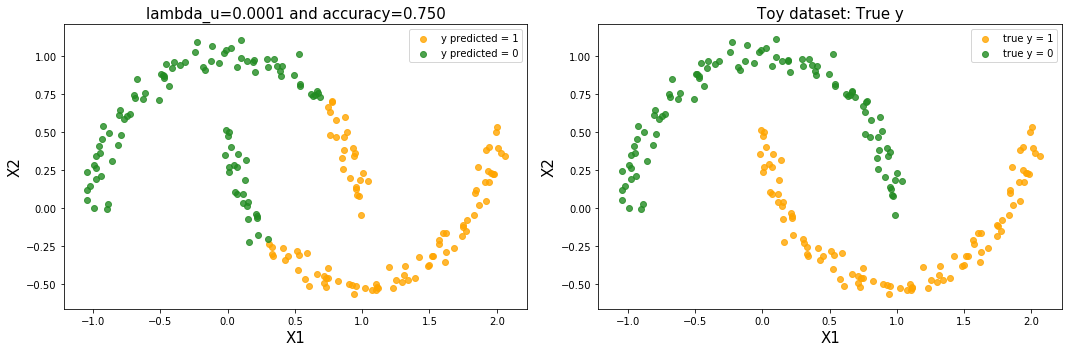

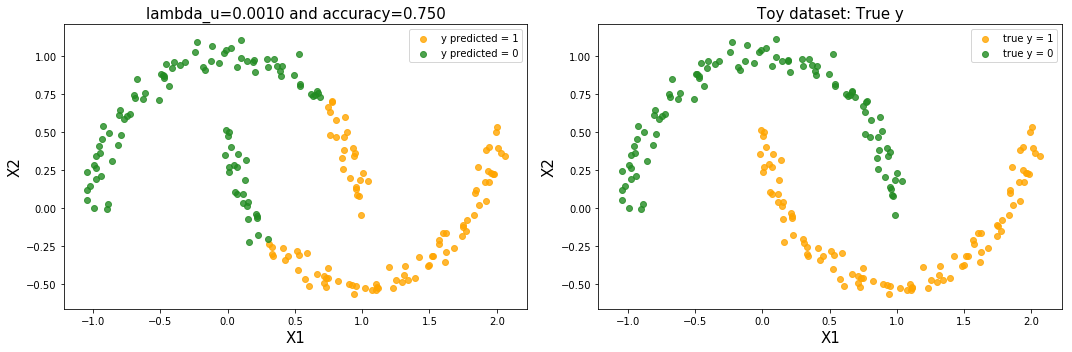

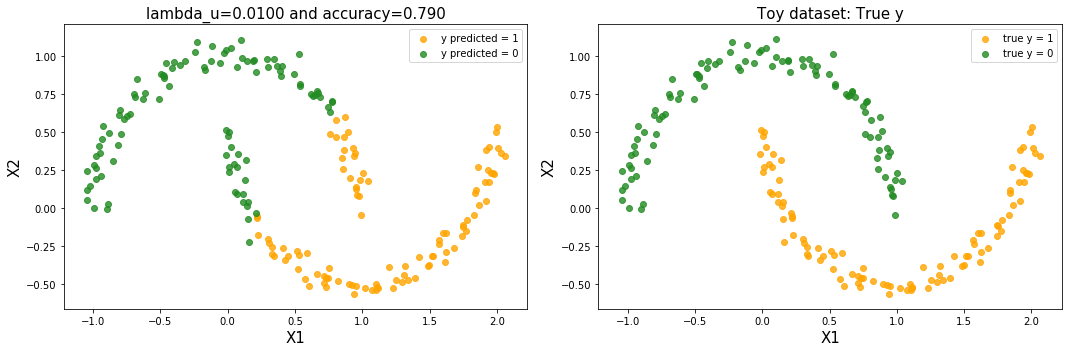

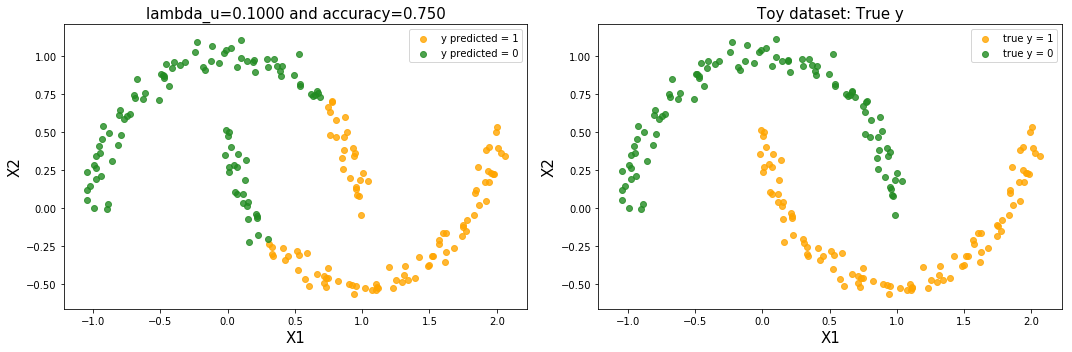

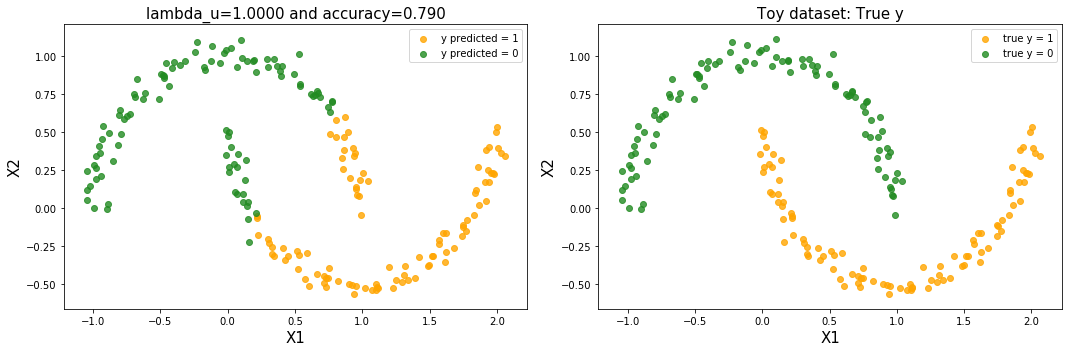

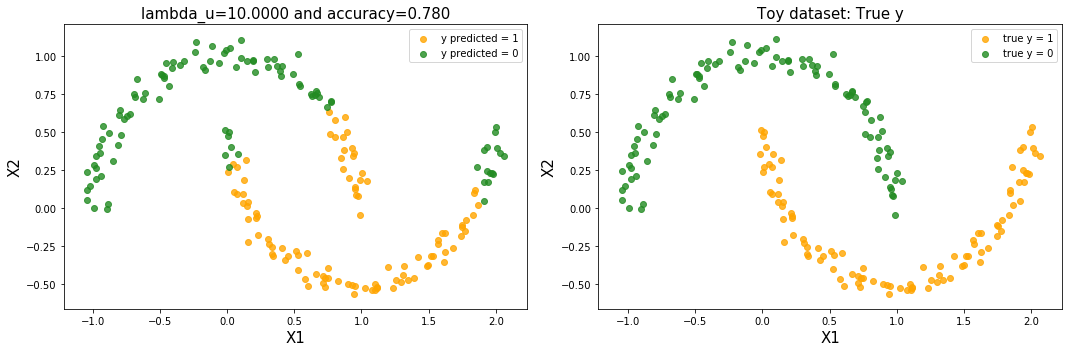

In [44]:
# Toy dataset
X_total = np.concatenate([Moons.X_lab, Moons.X_unlab])
y_total = np.concatenate([Moons.y_lab, Moons.y_unlab])
lbda_u_list = [0.0001, 0.001, 0.01, 0.1, 1, 10]
error_rate_toy_sgd = []

for lbda_u in lbda_u_list:
    y_continue = LapRLS_SGD(Moons, n_neighbors=5, lbda=0.01, lbda_u=lbda_u)
    pred = threshold_label(y_continue=y_continue)
    accuracy = accuracy_score(y_total, pred)
    error_rate_toy_sgd.append(np.linalg.norm(pred - y_total , 1) / len(y_total))
    title1 = "lambda_u=%0.04f and accuracy=%0.03f" % (lbda_u, accuracy)
    title2 = "Toy dataset: True y"
    plot_semisupervised(X_total, pred, y_total, title1, title2)

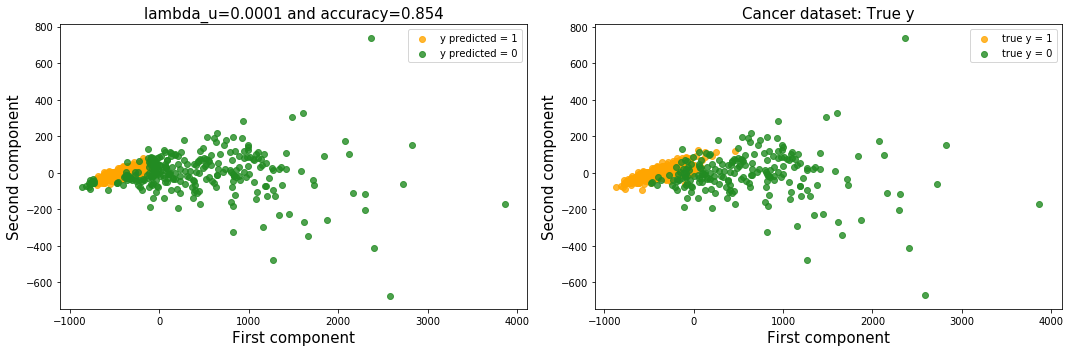

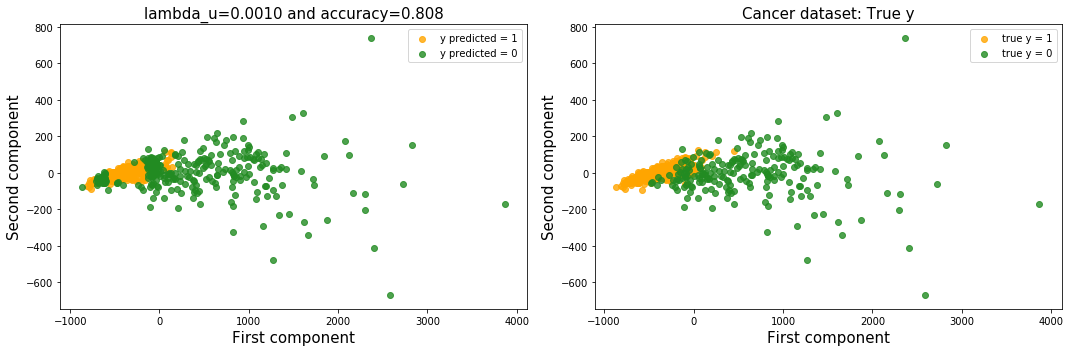

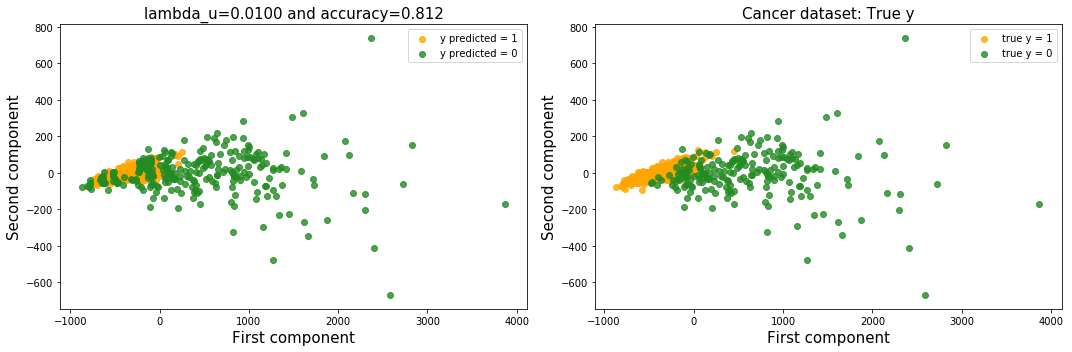

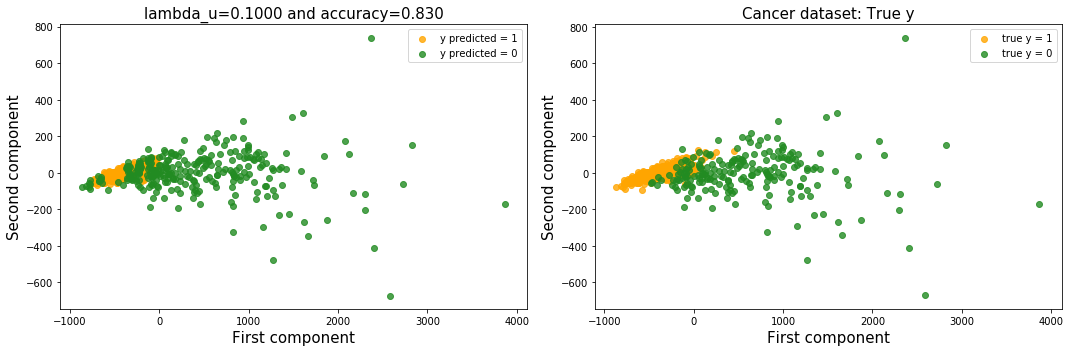

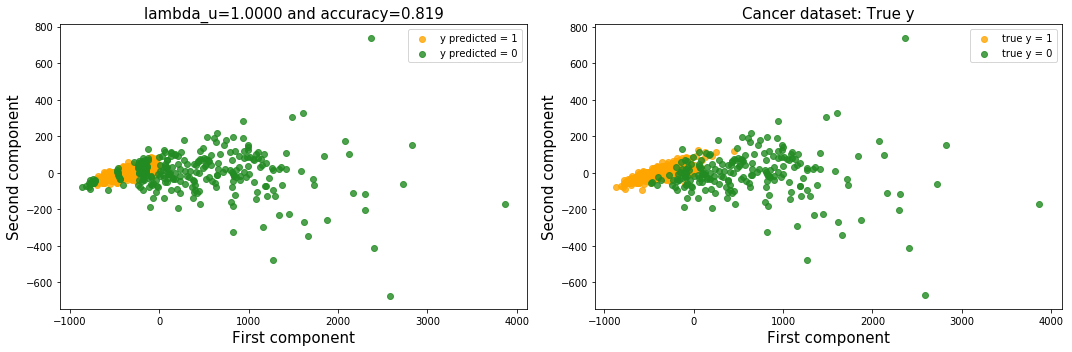

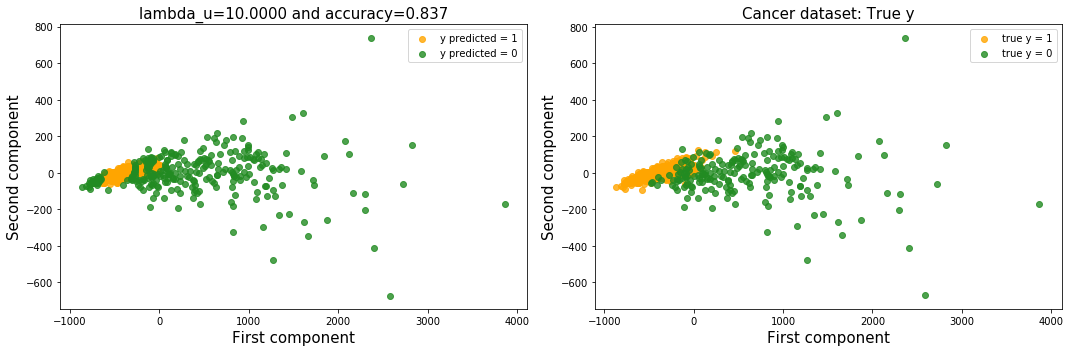

In [45]:
# Chosen dataset
X_total = np.concatenate([Cancer.X_lab, Cancer.X_unlab])
y_total = np.concatenate([Cancer.y_lab, Cancer.y_unlab])
error_rate_cancer_sgd = []

for lbda_u in lbda_u_list:
    y_continue = LapRLS_SGD(Cancer, n_neighbors=5, lbda=0.01, lbda_u=lbda_u)
    pred = threshold_label(y_continue=y_continue)
    accuracy = accuracy_score(y_total, pred)
    error_rate_cancer_sgd.append(np.linalg.norm(pred - y_total , 1) / len(y_total))
    title1 = "lambda_u=%0.04f and accuracy=%0.03f" % (lbda_u, accuracy)
    title2 = "Cancer dataset: True y"
    plot_semisupervised(X_total, pred, y_total, title1, title2, acp=True)

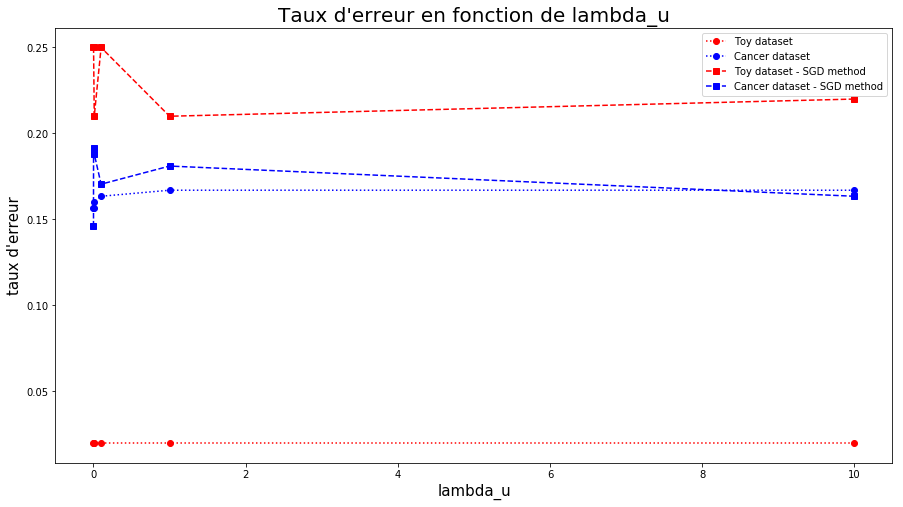

In [46]:
fig = plt.figure(1, figsize=(15, 8)) 

plt.plot(lbda_u_list , error_rate_toy, "r:o", label="Toy dataset")
plt.plot(lbda_u_list, error_rate_cancer, "b:o", label="Cancer dataset")
plt.plot(lbda_u_list, error_rate_toy_sgd, "rs--", label="Toy dataset - SGD method")
plt.plot(lbda_u_list, error_rate_cancer_sgd, "bs--", label="Cancer dataset - SGD method")
plt.legend()
plt.title("Taux d'erreur en fonction de lambda_u", fontsize=20)
plt.xlabel("lambda_u", fontsize=15)
plt.ylabel("taux d'erreur", fontsize=15)
plt.show()

#### Comment:
We observe an increase in the error rates when using the SGD method for the Toy dataset (red).  
For the Cancer dataset the error rate is approximately the same when using the SGD method.

For both datasets, the impact of $\lambda_u$ is a little bit larger than previously (i.e. without SGD) but remains very small. Moreover the effect of an increase in $\lambda_u$ is non-monotonous. The optimal value of $\lambda_u$ seems to be 0.0001 for the Cancer dataset.

### Question 15 : Complete the code in the box below

We solve the following problem

$$
\underset{f \in \mathcal{H}_K}{min} \frac{1}{l} \sum_{i=1}^l (1 - y_if(x_i))_+ + \lambda\| f \|_{K}^2 + \frac{\lambda_u}{(u+l)^2} f^\top L f
$$

By the representer theorem, the solution is given by

$$
f^*(x) = \sum_{j=1}^{l+u} K(x,x_j)\alpha_i^* + b
$$

So, the primal problem can be seen such that

$$
\underset{\alpha \in \mathbb{R}^{l + u}, \xi_i \in \mathbb{R}^l}{min} \frac{1}{l} \sum_{i=1}^l \xi_i + \lambda\alpha^TK\alpha + \frac{\lambda_u}{(u+l)^2}\alpha^TKLK\alpha$
$$

$$
subject \: to \: y_i(\sum_{j = 1}^{l + u}\alpha_jK(x_i, x_j) + b) \geqslant 1 - \xi_i, i = 1, ..., l \: and \: \xi_i \geqslant 0, i = 1, ..., l
$$

Introducing the Lagrangian with $\beta_i$ and $\zeta_i$ as Lagrange multipliers, we write:

$$
L(\alpha, \xi, b, \beta, \zeta) = \frac{1}{l}\sum_{i = 1}^l\xi_i + \frac{1}{2}\alpha^T(2\lambda K + 2\frac{\lambda_u}{(u+l)^2}KLK)\alpha - \sum_{i = 1}^l\beta_i(y_i(\sum_{j = 1}^{l + u}\alpha_jK(x_i, x_j) + b) - 1 + \xi_i) - \sum_{i = 1}^l\zeta_i\xi_i
$$

By derivating the Lagrangian with respect to $b$ and $\xi_i$, we obtain a reduced Lagrangian:

$$
L^R(\alpha, \beta) = \frac{1}{2}\alpha^T(2\lambda K + 2\frac{\lambda_u}{(u+l)^2}KLK)\alpha - \alpha^TKJ^TY\beta + \sum_{i = 1}^l\beta_i
$$

where $J = [I..0]$ and $Y = diag(y_1, y_2, ..., y_l)$. Taking the derivative with respect to $\alpha$ to 0 gives us:

$$
\alpha^* = (2\lambda I + 2\frac{\lambda_u}{(u+l)^2}LK)^{-1}J^TY\beta^{\star}
$$

Substituting this value back to the reduced Lagrangian, we get: 

$$
\beta^{\star} = \underset{\beta \in \mathbb{R}^l}{max} \sum_{i = 1}^l\beta_i - \frac{1}{2}\beta^TQ\beta
$$

$$
subject \: to: \: \sum_{i = 1}^l \beta_iy_i = 0 \: and \: 0 \leqslant \beta_i \leqslant \frac{1}{l}, \: i = 1, ..., l
$$

where 

$$
Q = YJK(2\lambda I + 2\frac{\lambda_u}{(u+l)^2}LK)^{-1}J^TY
$$

In [47]:
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False

def LapSVM(data, n_neighbors=5, lbda=0.01, lbda_u=0.001):
    
    X_lab = data.X_lab
    y_lab = data.y_lab 
    X_unlab = data.X_unlab
    y_unlab = data.y_unlab
    
    u = len(X_unlab)
    l = len(X_lab)
    n = u + l 
    
    # J matrix 
    J = np.hstack((np.identity(l),np.zeros((l,u)))) 

    # Y matrix
    Y = np.diag(y_lab)  

    # step 1. data adjency graph with (l+u) nodes using k nearest neighbors
    X_total = np.concatenate([X_lab, X_unlab])
    kn = kneighbors_graph(X_total, n_neighbors=n_neighbors, include_self=False)
    W = (kn + kn.T) / 2
    W[W > 0] = 1
    W = W.todense()
    
    # step 2. compute the Gram Matrix
    K = rbf_kernel(X_total)

    # step 3. comput graph Laplacian Matrix                         
    D = np.zeros((n, n))
    for i in range(n):
        D[i, i] = W[i, :].sum()
    L = D - W
    
    # step 4. choose the regularization parameters   
    lbda = lbda
    lbda_u = lbda_u

    # step 5. compute beta*
    
    # Q matrix
    inv = 2 * lbda * np.identity(n) + 2 * (lbda_u / n**2) * L.dot(K)
    inv = np.linalg.inv(inv)

    Q = Y.dot(J).dot(K).dot(inv).dot(J.T).dot(Y)
    
    # we reshape y_lab because its values must be -1 and +1, instead of 0 and 1
    y_lab_bis = y_lab.copy()
    y_lab_bis[y_lab == 0] = -1
    y_unlab_bis = y_unlab.copy()
    y_unlab_bis[y_unlab == 0] = -1

    # QP Solver
    p = matrix(Q)
    q = matrix(-1 * np.ones(l), (l, 1))
    A = matrix(y_lab_bis, (1, l), "d")
    b = matrix(0.0)
    
    G1 = np.array([0 for s in range(l)])
    G1[0]=1
    G2 = np.array([0 for s in range(l)])
    G2[0]=-1
    G = np.vstack((G1,G2))
    for i in range(l-1):
        G1 = np.roll(G1, 1)
        G2 = np.roll(G2, 1)
        G = np.vstack((G, G1))
        G = np.vstack((G, G2))
    G = matrix(G, (2*l, l), "d")

    h = [0 for i in range(2*l)]
    for j in range(2*l):
        if j % 2 == 0:
            h[j] = 1./l
    h = matrix(h)
    
    beta = solvers.qp(p, q, G, h, A, b)["x"]

    # step 5.bis compute alpha*
    alpha = inv.dot(J.T).dot(Y).dot(beta)

    # step 6. ouput function f*(x)
    f = K.dot(alpha)
    f = np.ravel(f).T

    return f

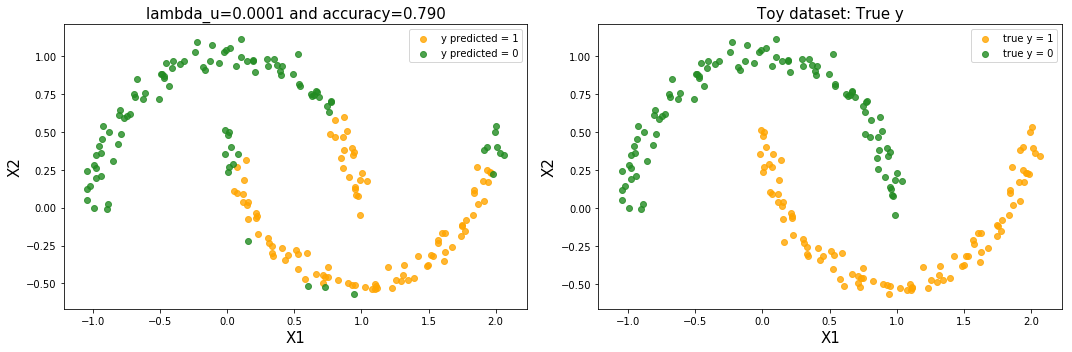

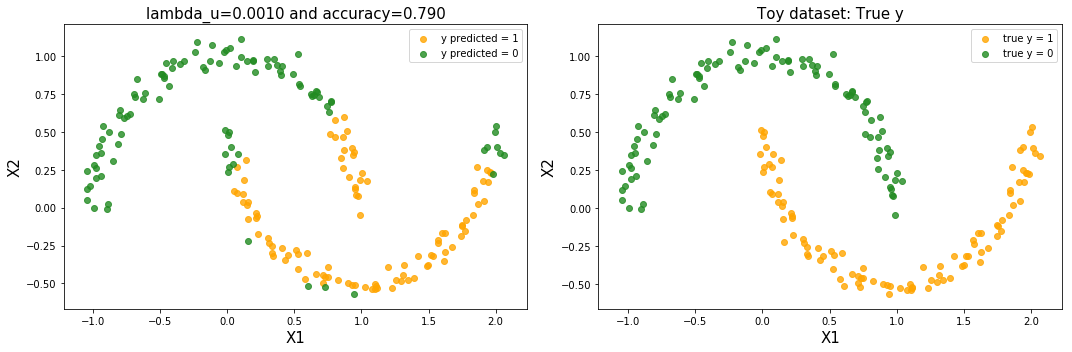

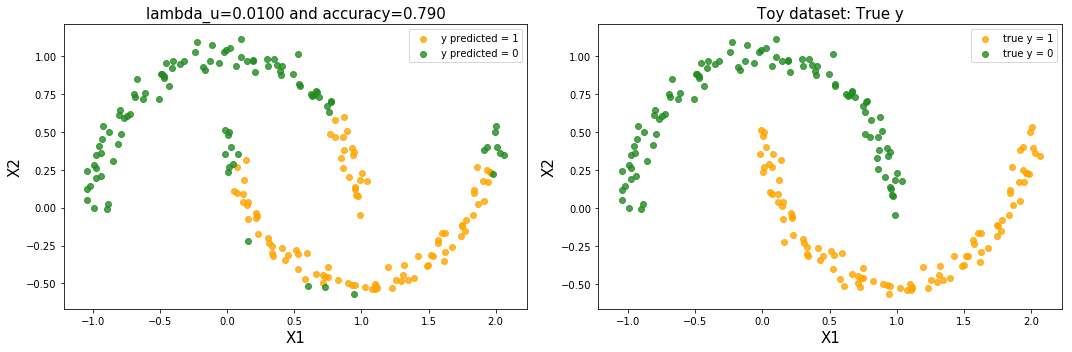

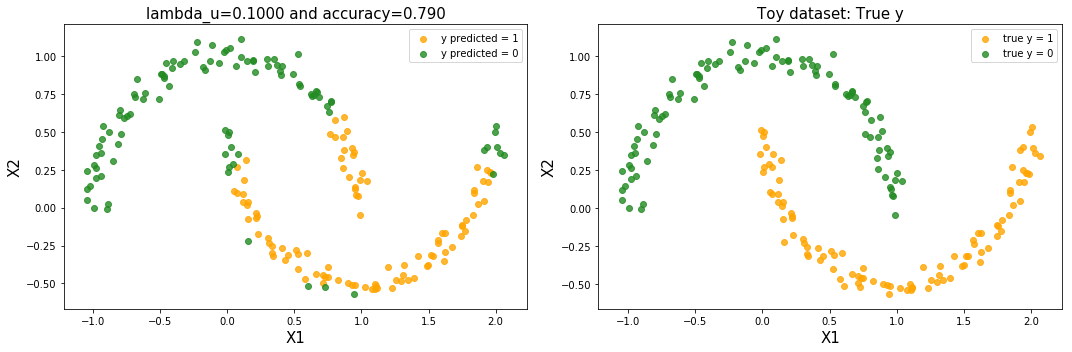

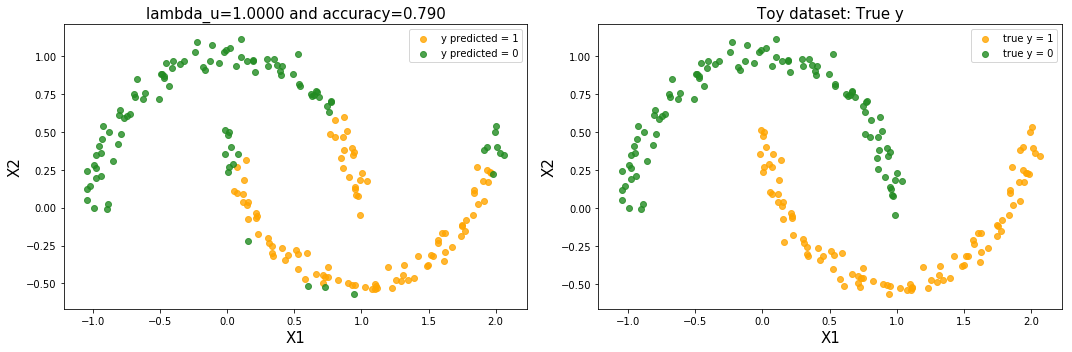

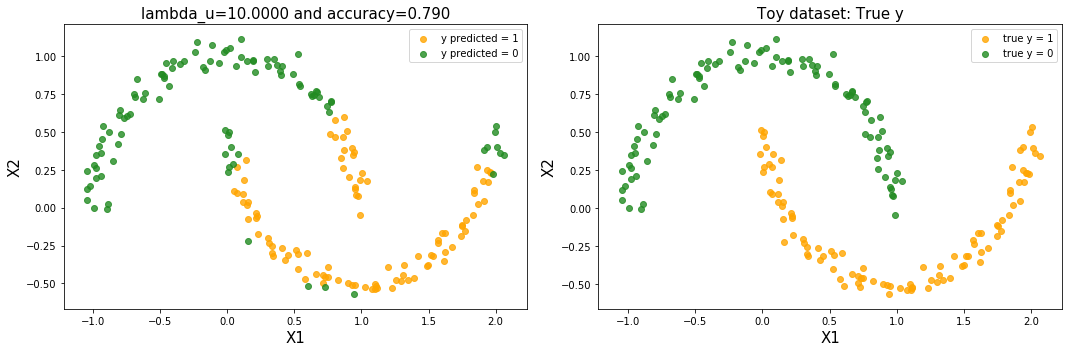

In [48]:
# Toy dataset
X_total = np.concatenate([Moons.X_lab, Moons.X_unlab])
y_total = np.concatenate([Moons.y_lab, Moons.y_unlab])
lbda_u_list = [0.0001, 0.001, 0.01, 0.1, 1, 10]
error_rate_toy = []

for lbda_u in lbda_u_list:
    y_continue = LapSVM(Moons, n_neighbors=5, lbda=0.01, lbda_u=lbda_u)
    pred = threshold_label(y_continue=y_continue)
    accuracy = accuracy_score(y_total, pred)
    error_rate_toy.append(np.linalg.norm(pred - y_total , 1) / len(y_total))
    title1 = "lambda_u=%0.04f and accuracy=%0.03f" % (lbda_u, accuracy)
    title2 = "Toy dataset: True y"
    plot_semisupervised(X_total, pred, y_total, title1, title2)

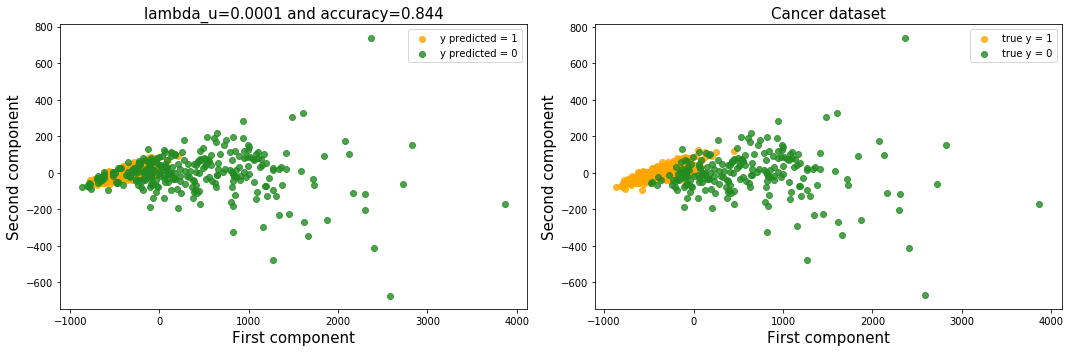

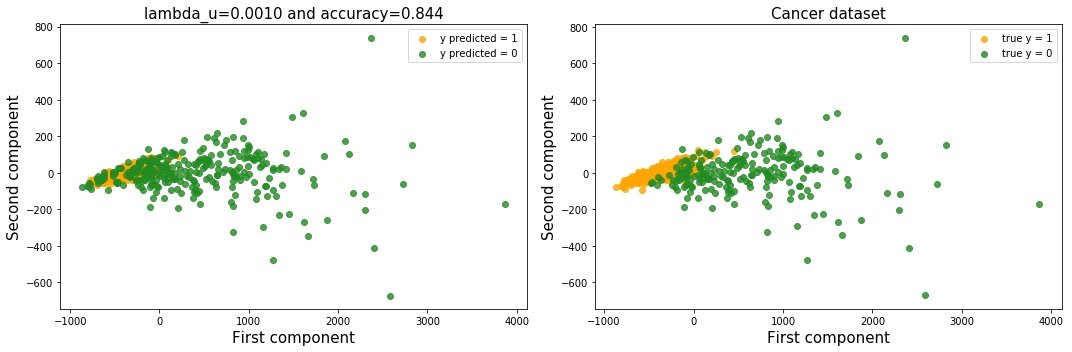

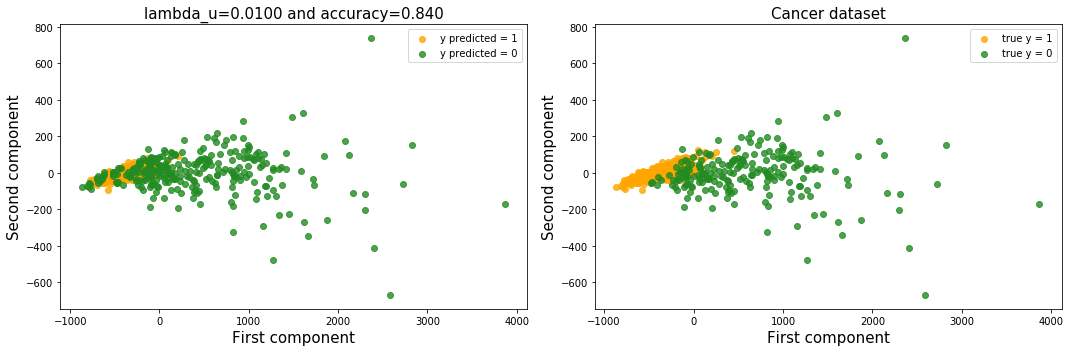

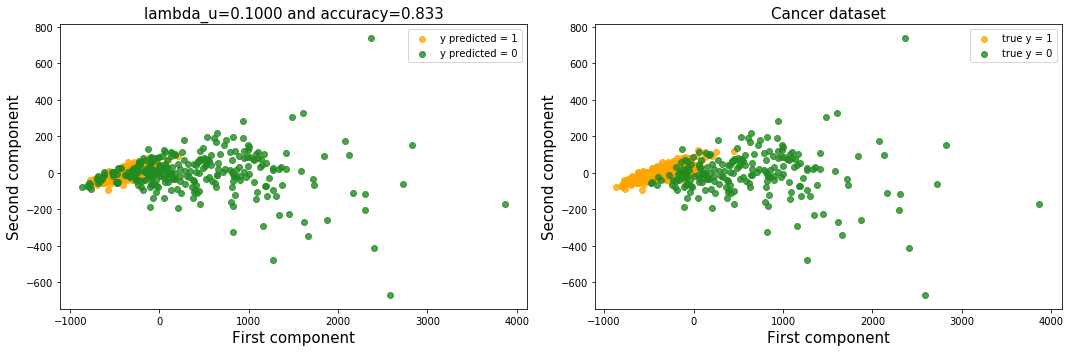

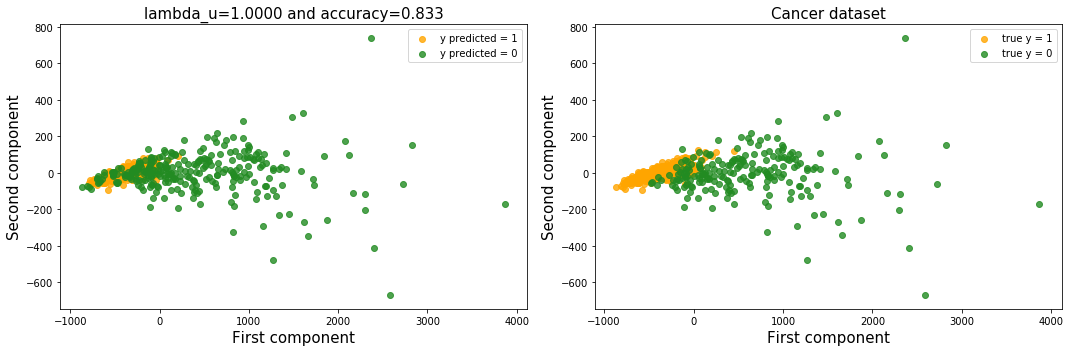

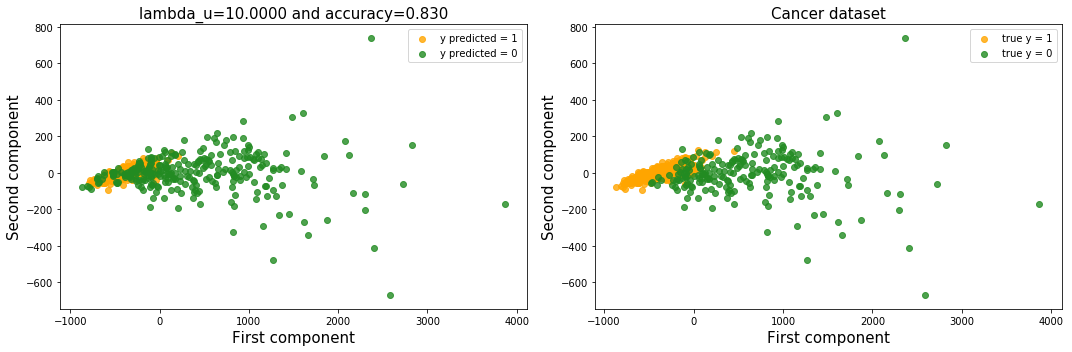

In [49]:
# Chosen dataset
X_total = np.concatenate([Cancer.X_lab, Cancer.X_unlab])
y_total = np.concatenate([Cancer.y_lab, Cancer.y_unlab])
error_rate_toy = []

for lbda_u in lbda_u_list:
    y_continue = LapSVM(Cancer, n_neighbors=5, lbda=0.01, lbda_u=lbda_u)
    pred = threshold_label(y_continue=y_continue)
    accuracy = accuracy_score(y_total, pred)
    error_rate_toy.append(np.linalg.norm(pred - y_total , 1) / len(y_total))
    title1 = "lambda_u=%0.04f and accuracy=%0.03f" % (lbda_u, accuracy)
    title2 = "Cancer dataset"
    plot_semisupervised(X_total, pred, y_total, title1, title2, acp=True)

#### Comment:
We obtain similar results as before.

## QUESTION 16

### Compare Self-training, LapRLS and LapSVM on a real dataset for various percentages of labeled data. For the self training algorithm, you can vary the base learner.

In [50]:
p_unlab_list = [0.0, 0.2, 0.5, 0.7, 0.9]
accuracy_self_train = []
accuracy_LapRLS = []
accuracy_LapRLS_SGD = []
accuracy_LapSVM = []

for p_unlabelled in p_unlab_list:
    Cancer = semi_sup_dat(load_breast_cancer(), p_unlabelled,'Cancer')
    X_total = np.concatenate([Cancer.X_lab, Cancer.X_unlab])
    y_total = np.concatenate([Cancer.y_lab, Cancer.y_unlab])
    
    # Self training algorithm
    S = self_training(Cancer)
    y_total = np.concatenate([Cancer.y_lab, Cancer.y_unlab])
    accuracy_self_train.append(accuracy_score(y_total, S[1]))
    
    # LapRLS --- note: we choose lbda_u=0.1
    y_continue = LapRLS(Cancer, n_neighbors=5, lbda=0.01, lbda_u=0.001)
    pred = threshold_label(y_continue=y_continue)
    accuracy_LapRLS.append(accuracy_score(y_total, pred))
    
    # LapRLS using SGD --- note: we choose lbda_u=0.1
    y_continue = LapRLS_SGD(Cancer, n_neighbors=5, lbda=0.01, lbda_u=0.001)
    pred = threshold_label(y_continue=y_continue)
    accuracy_LapRLS_SGD.append(accuracy_score(y_total, pred))
    
    # LapSVM --- note: we choose lbda_u=0.1
    y_continue = LapSVM(Cancer, n_neighbors=5, lbda=0.01, lbda_u=0.001)
    pred = threshold_label(y_continue=y_continue)
    accuracy_LapSVM.append(accuracy_score(y_total, pred))
    

50 iterations needed to label y_unlab
50 iterations needed to label y_unlab
50 iterations needed to label y_unlab
50 iterations needed to label y_unlab


In [51]:
for i,prop in enumerate(p_unlab_list): 
    print("Accuracy self_training = %.02f for p_unlabelled = %.01f " % (accuracy_self_train[i] , prop))

Accuracy self_training = 1.00 for p_unlabelled = 0.0 
Accuracy self_training = 0.92 for p_unlabelled = 0.2 
Accuracy self_training = 0.76 for p_unlabelled = 0.5 
Accuracy self_training = 0.67 for p_unlabelled = 0.7 
Accuracy self_training = 0.57 for p_unlabelled = 0.9 


In [52]:
for i,prop in enumerate(p_unlab_list): 
    print("Accuracy LapRLS = %.02f for p_unlabelled = %.01f " % (accuracy_LapRLS[i] , prop))

Accuracy LapRLS = 0.87 for p_unlabelled = 0.0 
Accuracy LapRLS = 0.87 for p_unlabelled = 0.2 
Accuracy LapRLS = 0.86 for p_unlabelled = 0.5 
Accuracy LapRLS = 0.84 for p_unlabelled = 0.7 
Accuracy LapRLS = 0.83 for p_unlabelled = 0.9 


In [53]:
for i,prop in enumerate(p_unlab_list): 
    print("Accuracy LapRLS using SGD = %.02f for p_unlabelled = %.01f " % (accuracy_LapRLS_SGD[i] , prop))

Accuracy LapRLS using SGD = 0.83 for p_unlabelled = 0.0 
Accuracy LapRLS using SGD = 0.84 for p_unlabelled = 0.2 
Accuracy LapRLS using SGD = 0.82 for p_unlabelled = 0.5 
Accuracy LapRLS using SGD = 0.82 for p_unlabelled = 0.7 
Accuracy LapRLS using SGD = 0.69 for p_unlabelled = 0.9 


In [54]:
for i,prop in enumerate(p_unlab_list): 
    print("Accuracy LapSVM = %.02f for p_unlabelled = %.01f " % (accuracy_LapSVM[i] , prop))

Accuracy LapSVM = 0.87 for p_unlabelled = 0.0 
Accuracy LapSVM = 0.87 for p_unlabelled = 0.2 
Accuracy LapSVM = 0.86 for p_unlabelled = 0.5 
Accuracy LapSVM = 0.84 for p_unlabelled = 0.7 
Accuracy LapSVM = 0.83 for p_unlabelled = 0.9 


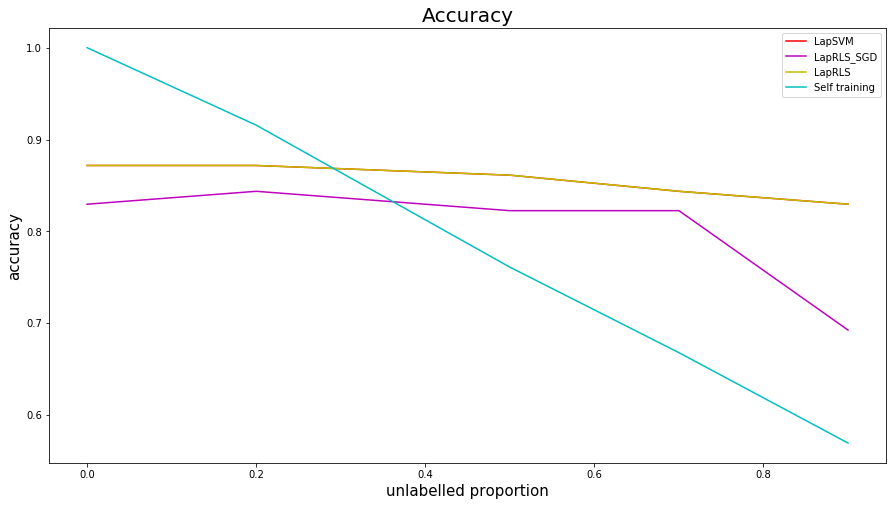

In [55]:
fig = plt.figure(1, figsize=(15, 8)) 

plt.plot(p_unlab_list , accuracy_LapSVM, "r", label="LapSVM")
plt.plot(p_unlab_list, accuracy_LapRLS_SGD, "m", label="LapRLS_SGD")
plt.plot(p_unlab_list, accuracy_LapRLS, "y", label="LapRLS")
plt.plot(p_unlab_list, accuracy_self_train, "c", label="Self training")
plt.legend()
plt.title("Accuracy", fontsize=20)
plt.xlabel("unlabelled proportion", fontsize=15)
plt.ylabel("accuracy", fontsize=15)
plt.show()

#### Comment : 

We observe that for a small proportion of unlabelled data, the self-training method results in a larger accuracy than the other algorithms.

However, the self-training algorithm is much more affected by the proportion of unlabelled data. It is due to the fact that when the proportion of unlabelled data gets larger, the classifier is learned by training on a sample that is smaller: errors are larger and thus unlabelled data are more likely to be badly labelled.

Besides, the performances of the LapLRS and LapSVM methods are very similar (the curves overlap): they are both graph-based approaches, the only difference lies in the formula for computing $\alpha^*$.

When the proportion of unlabelled data is very large (say 0.9 - accuracy equals to 0.83), the accuracy of the LapLRS and LapSVM algorithms is almost as good as when there is no unlabelled data (accuracy equals to 0.87). Nevertheless, the LapSVM approach is expensive and LapRLS_SGD should be preferred in high-dimension. Note that the accuracy of this algorithm decreases when the unlabelled proportion is large.


Finally, we can say that both LapRLS and LapSVM give good results, even though the parameters $\lambda$ and $\lambda_u$ have not been selected using a cross-validation. 